In [ ]:
# import libraries
import json
import pandas as pd
import numpy as np
import seaborn as sns
import math
import matplotlib.pyplot as plt
import cv2
import plotly.express as px
import scipy.stats as stats
from scipy.stats import multivariate_normal
from scipy.stats import norm
from scipy.stats import f_oneway
from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold, ParameterGrid
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

# modelling
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
import optuna


c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import Datasets

In [ ]:
apple_data = pd.read_json('datasets/s1/full_simplified_apple.ndjson', lines=True)
baseball_data = pd.read_json('datasets/s1/full_simplified_baseball.ndjson', lines=True)
circle_data = pd.read_json('datasets/s1/full_simplified_circle.ndjson', lines=True)
flower_data = pd.read_json('datasets/s1/full_simplified_flower.ndjson', lines=True)
square_data = pd.read_json('datasets/s1/full_simplified_square.ndjson', lines=True)
bridge_data = pd.read_json('datasets/s2/full_simplified_bridge.ndjson', lines=True)
cow_data = pd.read_json('datasets/s2/full_simplified_cow.ndjson', lines=True)
moustache_data = pd.read_json('datasets/s2/full_simplified_moustache.ndjson', lines=True)
speedboat_data = pd.read_json('datasets/s2/full_simplified_speedboat.ndjson', lines=True)
yoga_data = pd.read_json('datasets/s2/full_simplified_yoga.ndjson', lines=True)

In [ ]:
# sample 1000 observations from each class

apple = apple_data.sample(n=1000, random_state=42)
baseball = baseball_data.sample(n=1000, random_state=42)
circle = circle_data.sample(n=1000, random_state=42)
flower = flower_data.sample(n=1000, random_state=42)
square = square_data.sample(n=1000, random_state=42)
bridge = bridge_data.sample(n=1000, random_state=42)
cow = cow_data.sample(n=1000, random_state=42)
moustache = moustache_data.sample(n=1000, random_state=42)
speedboat = speedboat_data.sample(n=1000, random_state=42)
yoga = yoga_data.sample(n=1000, random_state=42)

Data Cleaning

In [ ]:
def parse_line(ndjson_line):
  sample = json.loads(ndjson_line)
  class_name = sample["word"]
  inkarray = sample["drawing"]
  stroke_lengths = [len(stroke[0]) for stroke in inkarray] #points in each stroke (#x-vals)
  total_points = sum(stroke_lengths) #total points across all strokes

  np_ink = np.zeros((total_points, 3), dtype=np.float32) #initialize array
  current_t = 0 #initialize time
  for stroke in inkarray:
    for i in [0, 1]:
      np_ink[current_t:(current_t + len(stroke[0])), i] = stroke[i] #copy coordinates into array
    current_t += len(stroke[0])
    np_ink[current_t - 1, 2] = 1 #mark stroke end with 1 in 3rd col
  
  #normalization: x,y in [0,1] range
  lower = np.min(np_ink[:, 0:2], axis=0) 
  upper = np.max(np_ink[:, 0:2], axis=0) 
  scale = upper - lower
  scale[scale == 0] = 1 #avoid division by zero by setting any zero-scale values to 1
  np_ink[:, 0:2] = (np_ink[:, 0:2] - lower) / scale

  #get deltas: diff b/w consecutive points for x,y
  np_ink[1:, 0:2] -= np_ink[0:-1, 0:2]
  np_ink = np_ink[1:, :] #remove 1st row as not imp
  return np_ink, class_name

In [13]:
datasets = [apple, baseball, circle, flower, square, bridge, cow, moustache, speedboat, yoga]
master_data = []
for dataset in datasets:
    for _, row in dataset.iterrows():
        master_data.append(parse_line(row.to_json()))

master_df = pd.DataFrame(master_data)
master_df.head()

0      1
0  [[-0.008032143, -0.055118114, 0.0], [-0.072289...  apple
1  [[-0.20197046, 0.007843137, 0.0], [-0.16256158...  apple
2  [[0.0, -0.02352944, 0.0], [-0.031963468, -0.05...  apple
3  [[-0.010869565, 0.043137282, 0.0], [0.07608695...  apple
4  [[0.0414508, -0.0745098, 0.0], [0.04663211, -0...  apple

Feature Engineering

In [ ]:
# fractal dimension computed via box counting algorithm for hu moments
def fractal_dimension(Z):
    Z = (Z > 0)
    #generate box sizes
    sizes = np.unique(np.floor(np.logspace(1, np.log10(min(Z.shape)), num=10, base=10)).astype(int))
    sizes = sizes[sizes > 0]
    counts = []
    for size in sizes:
        count = 0
        #slide box across image
        for i in range(0, Z.shape[0], size):
            for j in range(0, Z.shape[1], size):
                if np.any(Z[i:i+size, j:j+size]):
                    count += 1
        counts.append(count)
    if len(counts) > 1:
        coeffs = np.polyfit(np.log(sizes), np.log(counts), 1)
        return -coeffs[0]
    else:
        return 0

In [ ]:
def extract_features(ink):
    dx = ink[:, 0]
    dy = ink[:, 1]
    pen_up = ink[:, 2]
    
    stroke_lengths = [] #points per stroke
    count = 0
    for p in pen_up:
        count += 1
        if p == 1.0:
            stroke_lengths.append(count)
            count = 0
    if count > 0:
        stroke_lengths.append(count)
    
    # stroke movement features
    basic_features = {
        'mean_dx': np.mean(dx),
        'mean_dy': np.mean(dy),
        'std_dx': np.std(dx),
        'std_dy': np.std(dy),
        'max_dx': np.max(dx),
        'max_dy': np.max(dy),
        'min_dx': np.min(dx),
        'min_dy': np.min(dy),
        'num_strokes': int(np.sum(pen_up)), #total strokes
        'total_points': len(dx), #drawing length
        'avg_stroke_len': np.mean(stroke_lengths) if stroke_lengths else 0, #points b/w stroke ends
        'trajectory_len': np.sum(np.sqrt(dx**2 + dy**2)) #total path traveled
    }

    # statistical features
    stat_features = {
        'skew_dx': stats.skew(dx),
        'skew_dy': stats.skew(dy),
        'kurtosis_dx': stats.kurtosis(dx),
        'kurtosis_dy': stats.kurtosis(dy),
        'q25_dx': np.percentile(dx, 25),
        'q75_dx': np.percentile(dx, 75),
        'q25_dy': np.percentile(dy, 25),
        'q75_dy': np.percentile(dy, 75)
    }
    
    # geometric/spatial features
    #reconstruct abs coordinates (starting point (0,0))
    abs_x = np.concatenate(([0], np.cumsum(dx)))
    abs_y = np.concatenate(([0], np.cumsum(dy)))
    
    #bounding box
    bbox_min_x, bbox_max_x = np.min(abs_x), np.max(abs_x)
    bbox_min_y, bbox_max_y = np.min(abs_y), np.max(abs_y)
    bbox_width = bbox_max_x - bbox_min_x
    bbox_height = bbox_max_y - bbox_min_y
    bbox_area = bbox_width * bbox_height
    bbox_perimeter = 2 * (bbox_width + bbox_height)
    bbox_diagonal = np.sqrt(bbox_width**2 + bbox_height**2)
    aspect_ratio = bbox_width / bbox_height if bbox_height != 0 else 0

    #centroid of drawing points
    centroid_x = np.mean(abs_x)
    centroid_y = np.mean(abs_y)
    
    #dist from centroid
    distances = np.sqrt((abs_x - centroid_x)**2 + (abs_y - centroid_y)**2)
    avg_distance = np.mean(distances)
    std_distance = np.std(distances)
    
    #start, end dist to centroid
    start_to_centroid = np.sqrt((abs_x[0]-centroid_x)**2 + (abs_y[0]-centroid_y)**2)
    end_to_centroid = np.sqrt((abs_x[-1]-centroid_x)**2 + (abs_y[-1]-centroid_y)**2)

    geo_features = {
        'bbox_width': bbox_width,
        'bbox_height': bbox_height,
        'bbox_area': bbox_area,
        'bbox_perimeter': bbox_perimeter,
        'bbox_diagonal': bbox_diagonal,
        'aspect_ratio': aspect_ratio,
        'centroid_x': centroid_x,
        'centroid_y': centroid_y,
        'start_to_centroid': start_to_centroid,
        'end_to_centroid': end_to_centroid,
        'avg_distance_to_centroid': avg_distance,
        'std_distance_to_centroid': std_distance
    }

    # convex hull features
    points = np.stack((abs_x, abs_y), axis=1)
    if len(points) >= 3:
        try:
            hull = ConvexHull(points)
            hull_area = hull.volume #for 2D, vol is area
            hull_perimeter = hull.area #for 2D, area is perimeter
        except Exception:
            hull_area = 0
            hull_perimeter = 0
    else:
        hull_area = 0
        hull_perimeter = 0

    #create binary representation of drawing
    img_size = 256
    img = np.zeros((img_size, img_size), dtype=np.uint8)
    #convert normalized coordinates to pixel indices
    pixel_x = np.clip((abs_x * (img_size - 1)).astype(int), 0, img_size - 1)
    pixel_y = np.clip((abs_y * (img_size - 1)).astype(int), 0, img_size - 1)
    for x, y in zip(pixel_x, pixel_y):
        img[y, x] = 255
    drawing_area = np.sum(img > 0)
    #convert drawing area to [0,1]
    drawing_area_cont = drawing_area / (img_size * img_size)
    solidity = drawing_area_cont / hull_area if hull_area != 0 else 0
    
    geo_features.update({
        'hull_area': hull_area,
        'hull_perimeter': hull_perimeter,
        'solidity': solidity
    })

    # angular/curvature features
    #get segment angles
    angles = np.arctan2(dy, dx)
    angles_unwrapped = np.unwrap(angles)
    diff_angles = np.abs(np.diff(angles_unwrapped))
    total_angle_change = np.sum(diff_angles)
    mean_segment_angle = np.mean(angles) if len(angles) > 0 else 0
    std_segment_angle = np.std(angles) if len(angles) > 0 else 0
    max_angle_change = np.max(diff_angles) if len(diff_angles) > 0 else 0
    min_angle_change = np.min(diff_angles) if len(diff_angles) > 0 else 0

    #get curvature (angle change per unit length)
    seg_lengths = np.sqrt(dx[1:]**2 + dy[1:]**2)
    with np.errstate(divide='ignore', invalid='ignore'):
        curvature = np.where(seg_lengths != 0, diff_angles / seg_lengths, 0)
    avg_curvature = np.mean(curvature) if len(curvature) > 0 else 0
    max_curvature = np.max(curvature) if len(curvature) > 0 else 0
    std_curvature = np.std(curvature) if len(curvature) > 0 else 0

    angle_features = {
        'total_angle_change': total_angle_change,
        'mean_segment_angle': mean_segment_angle,
        'std_segment_angle': std_segment_angle,
        'max_angle_change': max_angle_change,
        'min_angle_change': min_angle_change,
        'avg_curvature': avg_curvature,
        'max_curvature': max_curvature,
        'std_curvature': std_curvature
    }

    # stroke-based features
    longest_stroke = np.max(stroke_lengths) if stroke_lengths else 0
    shortest_stroke = np.min(stroke_lengths) if stroke_lengths else 0
    ratio_longest_shortest = longest_stroke / shortest_stroke if shortest_stroke != 0 else 0
    var_stroke_lengths = np.var(stroke_lengths) if stroke_lengths else 0

    #get pen-up (stroke end marks) jump distances
    pen_up_indices = np.where(pen_up == 1)[0]
    jump_distances = []
    for idx in pen_up_indices:
        #stroke end is at index idx+1 (bcz added initial point)
        if idx+1 < len(abs_x):
            d_jump = np.sqrt((abs_x[idx+1] - abs_x[idx])**2 + (abs_y[idx+1] - abs_y[idx])**2)
            jump_distances.append(d_jump)
    avg_jump_distance = np.mean(jump_distances) if jump_distances else 0
    std_jump_distance = np.std(jump_distances) if jump_distances else 0

    stroke_features = {
        'longest_stroke': longest_stroke,
        'shortest_stroke': shortest_stroke,
        'ratio_longest_shortest': ratio_longest_shortest,
        'var_stroke_lengths': var_stroke_lengths,
        'avg_jump_distance': avg_jump_distance,
        'std_jump_distance': std_jump_distance
    }

    # frequency features via fourier transform
    #complex signal representation (combine abs x & y)
    complex_signal = abs_x + 1j * abs_y
    fft_vals = np.fft.fft(complex_signal)
    freqs = np.fft.fftfreq(len(complex_signal))
    fft_magnitude = np.abs(fft_vals)
    fft_magnitude[0] = 0  # ignore the DC component
    dominant_idx = np.argmax(fft_magnitude)
    dominant_frequency = np.abs(freqs[dominant_idx])
    
    freq_features = {
        'dominant_frequency': dominant_frequency
    }

    # image-based features: Hu Moments
    #get image input
    moments = cv2.moments(img)
    hu_moments_arr = cv2.HuMoments(moments).flatten()
    #save each Hu moment individually
    hu_features = {f'hu_{i+1}': hu_moments_arr[i] for i in range(len(hu_moments_arr))}
    
    #fractal dimension computed via box counting algorithm
    fd = fractal_dimension(img)
    img_features = {'fractal_dimension': fd}
    
    # straightness/tortuosity
    straight_line_distance = np.sqrt((abs_x[-1]-abs_x[0])**2 + (abs_y[-1]-abs_y[0])**2)
    straightness = straight_line_distance / (basic_features['trajectory_len'] if basic_features['trajectory_len'] != 0 else 1)
    path_features = {
        'straightness': straightness
    }
    
    #combine all features
    features = {}
    features.update(basic_features)
    features.update(stat_features)
    features.update(geo_features)
    features.update(angle_features)
    features.update(stroke_features)
    features.update(freq_features)
    features.update(hu_features)
    features.update(img_features)
    features.update(path_features)

    return features


In [ ]:
feature_rows = []

for ink, class_name in master_df.itertuples(index=False):
    features = extract_features(ink)
    features['label'] = class_name
    feature_rows.append(features)

master_df1 = pd.DataFrame(feature_rows)

In [19]:
master_df1.head()

mean_dx   mean_dy    std_dx    std_dy    max_dx    max_dy    min_dx  \
0  0.004990 -0.011572  0.087296  0.102013  0.152610  0.385827 -0.244980   
1  0.000290 -0.001038  0.102617  0.092339  0.177340  0.250980 -0.305419   
2  0.001268 -0.000436  0.084029  0.094705  0.237443  0.137255 -0.196347   
3  0.017882 -0.012524  0.126972  0.102816  0.358696  0.356863 -0.320652   
4  0.002703  0.008525  0.078510  0.148086  0.176166  0.811765 -0.170985   

     min_dy  num_strokes  total_points  ...      hu_1      hu_2      hu_3  \
0 -0.192913            1            33  ...  1.170472  0.238548  0.335720   
1 -0.223529            3            34  ...  1.098029  0.322701  0.205298   
2 -0.301961            1            36  ...  0.867751  0.013007  0.050805   
3 -0.176471            3            31  ...  1.144630  0.155011  0.002491   
4 -0.168627            2            46  ...  0.450682  0.024552  0.004770   

       hu_4      hu_5      hu_6      hu_7  fractal_dimension  straightness  \
0  0.005337  0.000033  0.000592  0.000224           0.989488      0.114169   
1  0.001013 -0.000010  0.000542 -0.000011           0.993390      0.009007   
2  0.003590  0.000009 -0.000075 -0.000048           1.071325      0.011895   
3  0.039943  0.000025 -0.014138  0.000398           0.970435      0.156510   
4  0.016922 -0.000014  0.001863  0.000151           1.135806      0.072995   

   label  
0  apple  
1  apple  
2  apple  
3  apple  
4  apple  

[5 rows x 60 columns]

In [10]:
master_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 60 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   mean_dx                   10000 non-null  float32
 1   mean_dy                   10000 non-null  float32
 2   std_dx                    10000 non-null  float32
 3   std_dy                    10000 non-null  float32
 4   max_dx                    10000 non-null  float32
 5   max_dy                    10000 non-null  float32
 6   min_dx                    10000 non-null  float32
 7   min_dy                    10000 non-null  float32
 8   num_strokes               10000 non-null  int64  
 9   total_points              10000 non-null  int64  
 10  avg_stroke_len            10000 non-null  float64
 11  trajectory_len            10000 non-null  float32
 12  skew_dx                   10000 non-null  float64
 13  skew_dy                   10000 non-null  float64
 14  kurtosi

Data Normalization

In [ ]:
col = master_df1.columns.tolist()[:-1]

# scale features with z-score normalization
scaler = StandardScaler()
df_scaled_zscore = scaler.fit_transform(master_df1[col])
df_scaled_zscore = pd.DataFrame(df_scaled_zscore, columns=col)
df_scaled_zscore = pd.concat([df_scaled_zscore, master_df1.drop(columns=col)], axis=1)

# scale features to [0,1] scale with min-max scaling
scaler = MinMaxScaler()
df_scaled_minmax = scaler.fit_transform(master_df1[col])
df_scaled_minmax = pd.DataFrame(df_scaled_minmax, columns=col)
df_scaled_minmax = pd.concat([df_scaled_minmax, master_df1.drop(columns=col)], axis=1)

In [ ]:
# compute silhouette score

def silhouette_analysis(df, title):
    X = df.drop(columns=['label'])
    n_clusters = len(np.unique(df['label']))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    print(f"{title}: Silhouette Score = {score:.3f}")

silhouette_analysis(master_df1, "No Scaling")
silhouette_analysis(df_scaled_zscore, "Z-Scaling")
silhouette_analysis(df_scaled_minmax, "MinMax Scaling")


No Scaling: Silhouette Score = 0.478
Z-Scaling: Silhouette Score = 0.084
MinMax Scaling: Silhouette Score = 0.162


In [ ]:
# use t-SNE plot to visualize class separability

def plot_tsne(df, title):
    X = df.drop(columns=['label']).values
    labels = df['label']
    label_factors, unique = pd.factorize(labels)
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    X_embedded = tsne.fit_transform(X)
    df_viz = pd.DataFrame({
        'x': X_embedded[:, 0],
        'y': X_embedded[:, 1],
        'label': labels
    })
    plt.figure(figsize=(12, 10))
    sns.scatterplot(data=df_viz, x='x', y='y', hue='label', palette='tab10', s=60, alpha=0.8)
    plt.title(title)
    plt.legend(loc='best', bbox_to_anchor=(1.05, 1))
    plt.tight_layout()
    plt.show()


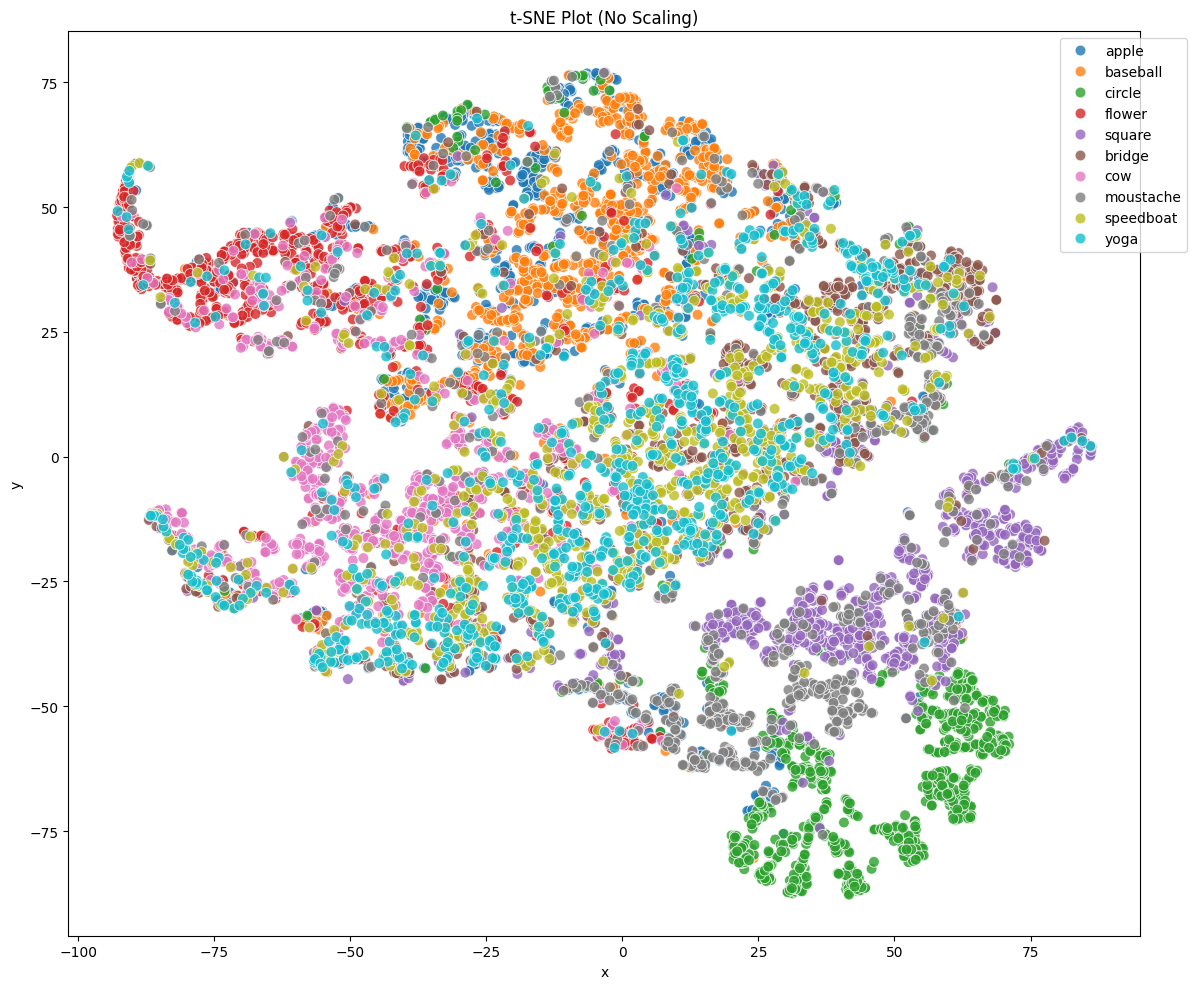

In [64]:
plot_tsne(master_df1, title="t-SNE Plot (No Scaling)")

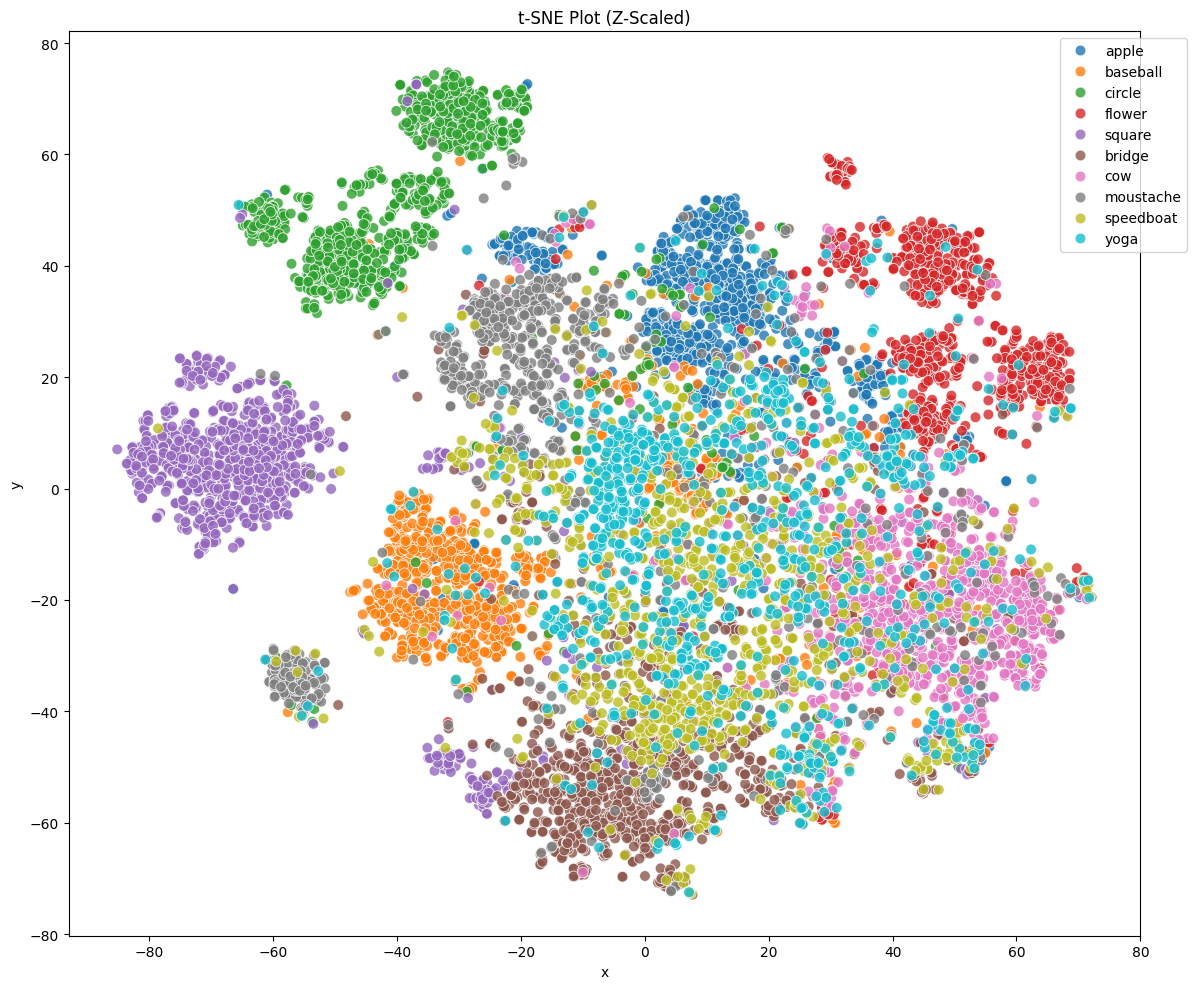

In [65]:
plot_tsne(df_scaled_zscore, title="t-SNE Plot (Z-Scaled)")

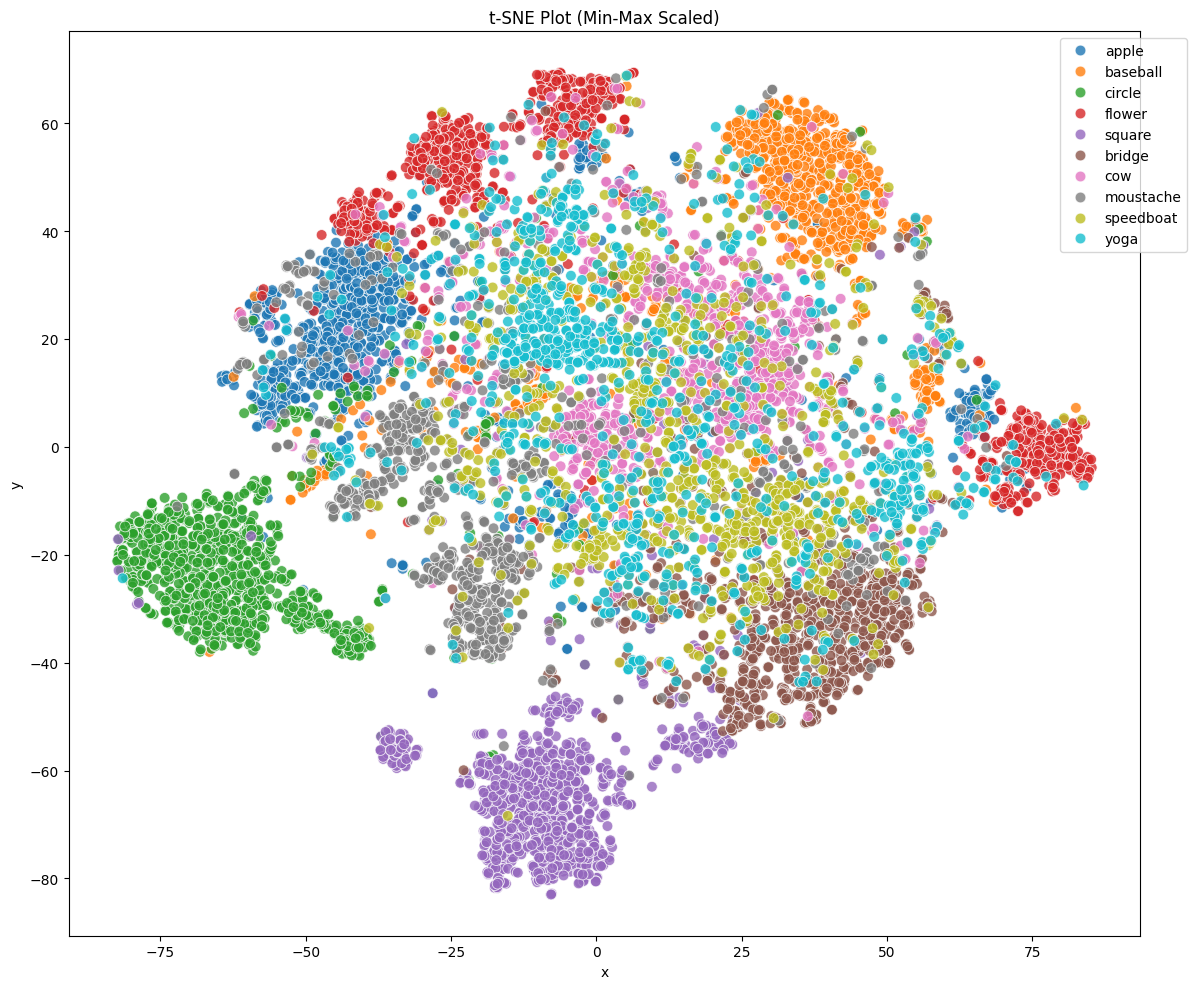

In [66]:
plot_tsne(df_scaled_minmax, title="t-SNE Plot (Min-Max Scaled)")

Exploratory Data Analysis

(using z-score scaled data since best clustering)

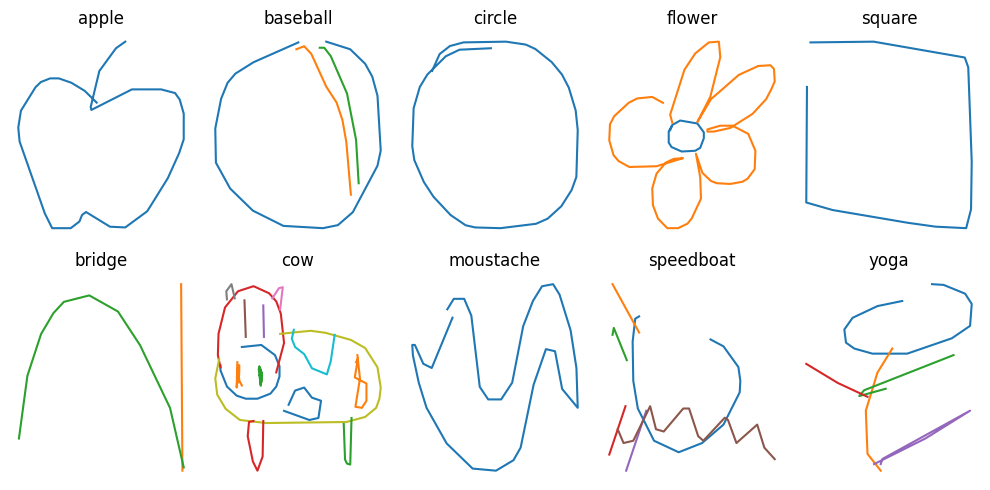

In [ ]:
# reconstruct drawings for each class

def reconstruct_drawing(ink):
    #convert deltas back to absolute positions
    points = np.cumsum(ink[:, :2], axis=0)
    stroke_ends = ink[:, 2]
    return points, stroke_ends

def plot_drawing(ink, class_name, ax):
    points, stroke_ends = reconstruct_drawing(ink)
    start_idx = 0
    for i, is_end in enumerate(stroke_ends):
        if is_end:
            stroke = points[start_idx:i+1]
            ax.plot(stroke[:, 0], -stroke[:, 1])
            start_idx = i + 1
    ax.set_title(class_name)
    ax.axis('off')

classes = ['apple', 'baseball', 'circle', 'flower', 'square', 
           'bridge', 'cow', 'moustache', 'speedboat', 'yoga']

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.flatten()
for i, class_name in enumerate(classes):
    class_samples = master_df[master_df[1] == class_name]
    if not class_samples.empty:
        ink = class_samples.iloc[0, 0]  # get first sample for class
        plot_drawing(ink, class_name, axes[i])

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

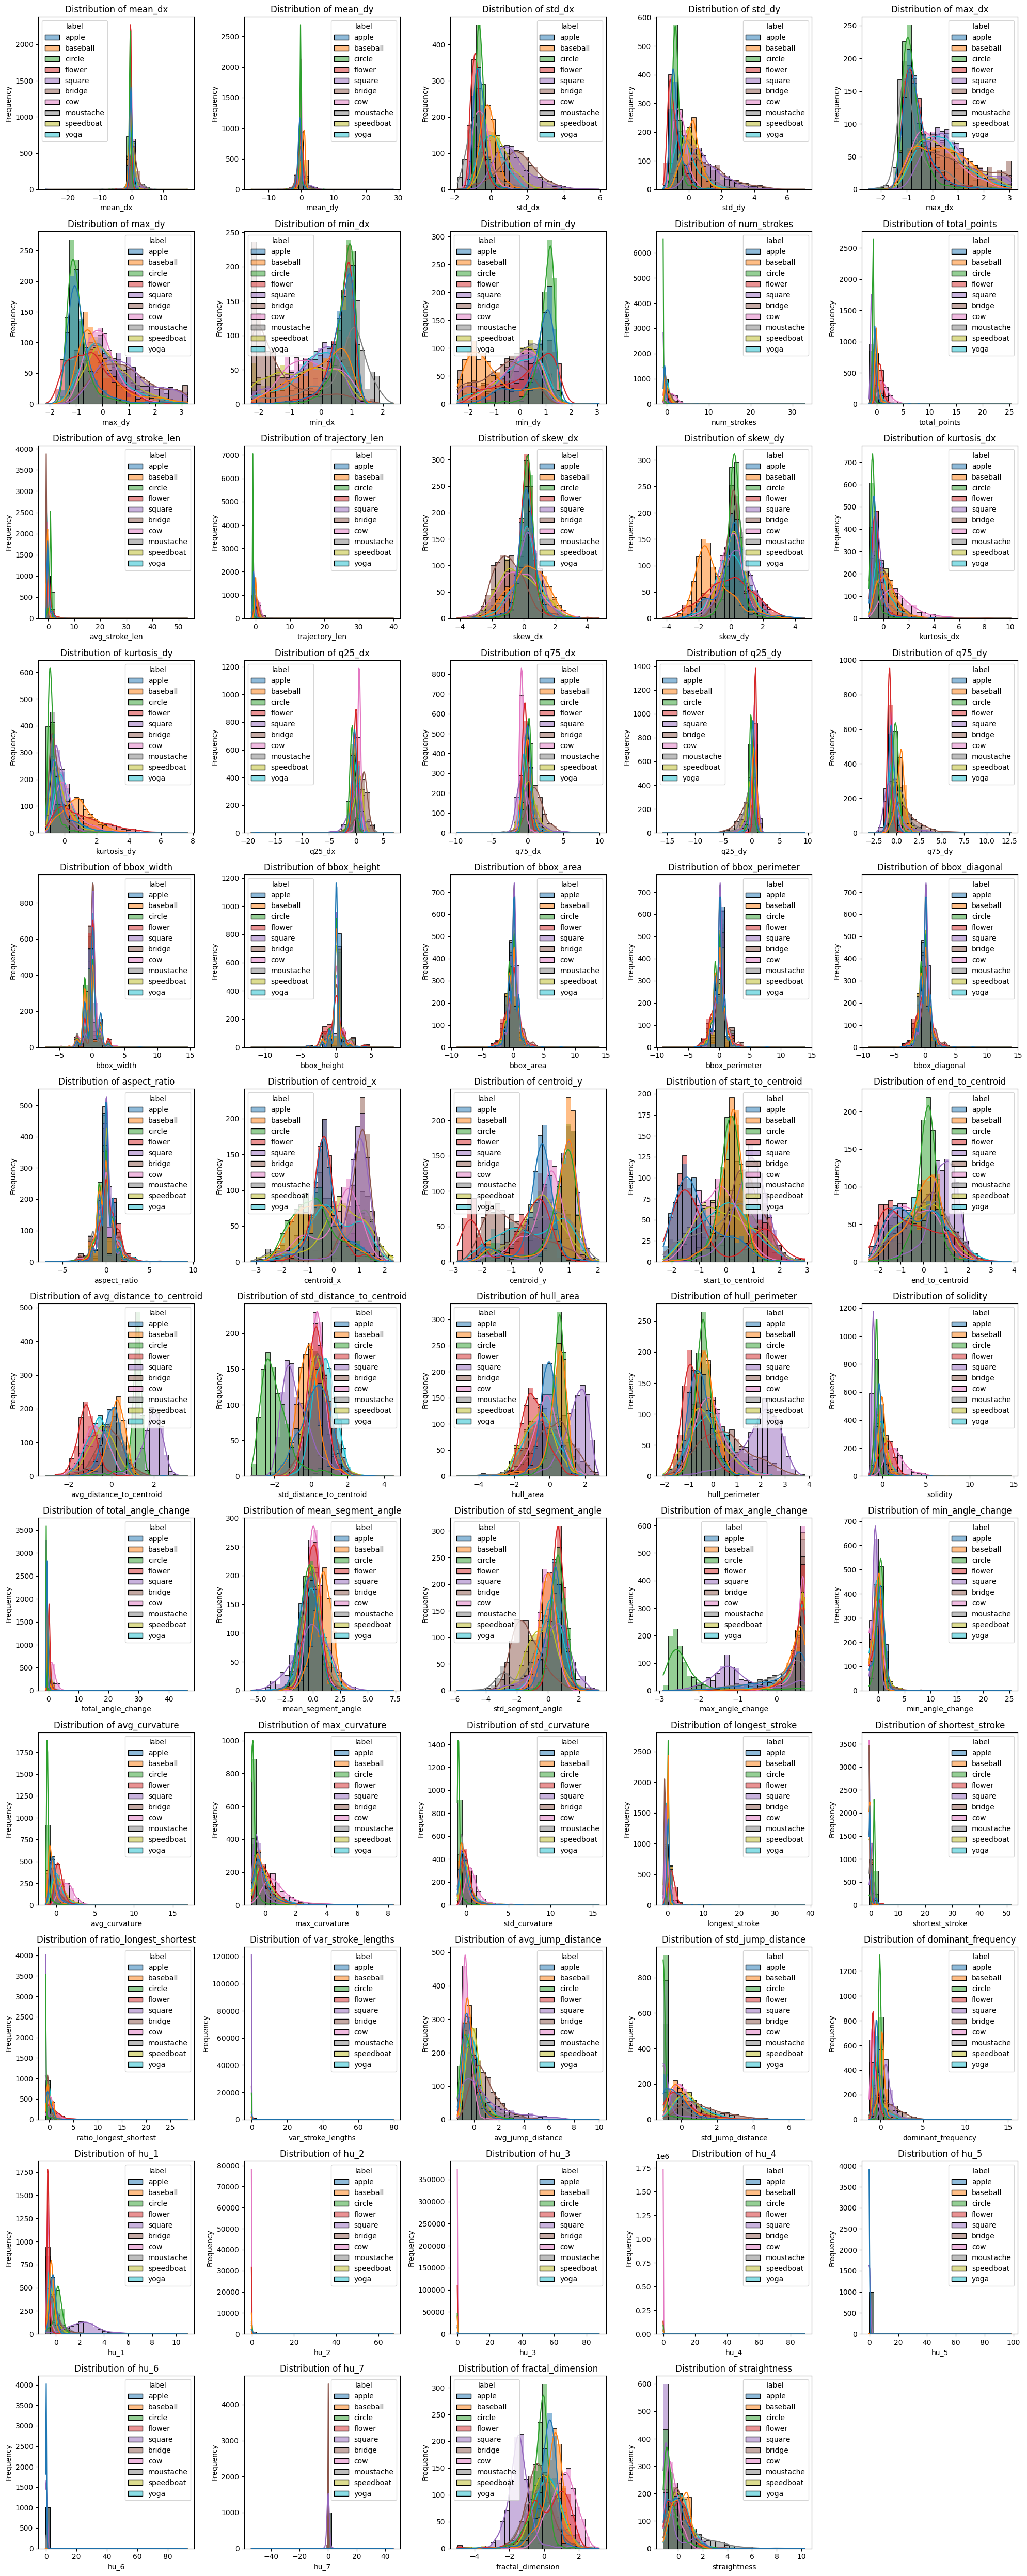

In [ ]:
# plot distribution for each feature

features = [col for col in df_scaled_zscore.columns if col != 'label']

fig, axes = plt.subplots(12, 5, figsize=(20, 50))
axes = axes.flatten()
for ax, feature in zip(axes, features):
    sns.histplot(data=df_scaled_zscore, x=feature, hue="label", bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')

for ax in axes[len(features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

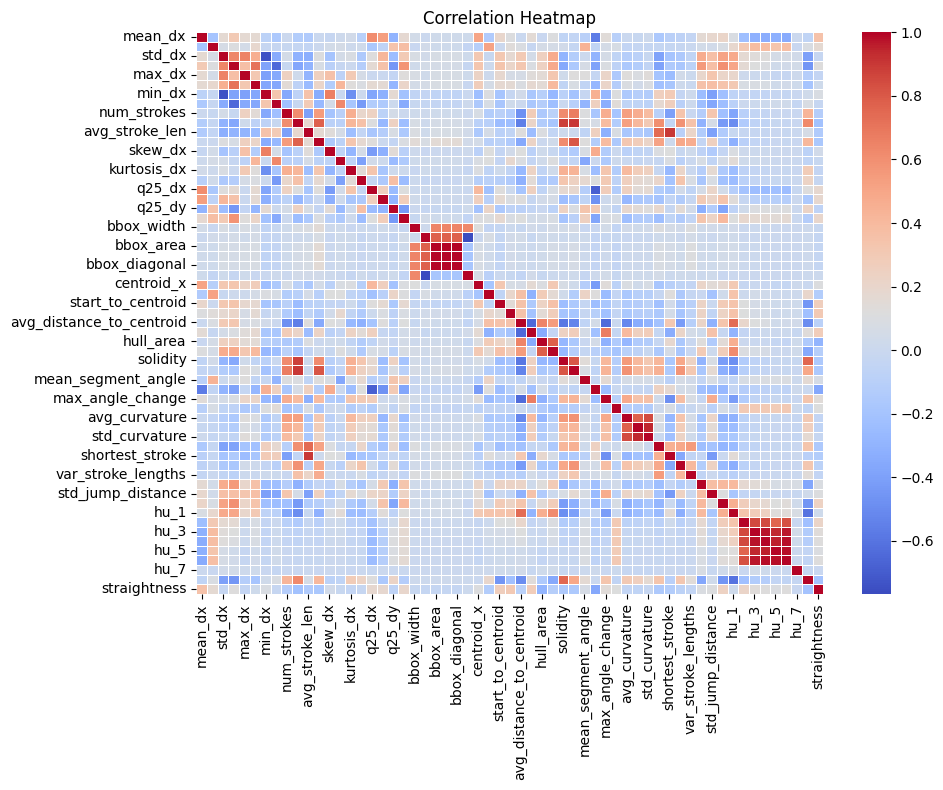

In [ ]:
# correlation matrix

correlation_matrix = df_scaled_zscore[col].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()

Pre-Processing

In [11]:
# train-val-test split function

def create_splits(df, test_size, val_size, random_state):
    train_data, temp_data = train_test_split(df, test_size=test_size, random_state=random_state)
    val_data, test_data = train_test_split(temp_data, test_size=val_size, random_state=random_state)
    train_df = pd.DataFrame(train_data)
    val_df = pd.DataFrame(val_data)
    test_df = pd.DataFrame(test_data)
    return train_df, val_df, test_df

# 70-30 split
train_df70, val_df70, test_df70 = create_splits(df_scaled_zscore, test_size=0.3, val_size=0.5, random_state=42)
print("70-30 Split - Train Set Class Distribution:")
print(train_df70['label'].value_counts())

# 80-20 split
train_df80, val_df80, test_df80 = create_splits(df_scaled_zscore, test_size=0.2, val_size=0.5, random_state=42)
print("\n80-20 Split - Train Set Class Distribution:")
print(train_df80['label'].value_counts())

# 90-10 split
train_df90, val_df90, test_df90 = create_splits(df_scaled_zscore, test_size=0.1, val_size=0.5, random_state=42)
print("\n90-10 Split - Train Set Class Distribution:")
print(train_df90['label'].value_counts())


70-30 Split - Train Set Class Distribution:
label
yoga         735
circle       712
bridge       710
moustache    708
cow          708
flower       697
baseball     692
apple        682
square       680
speedboat    676
Name: count, dtype: int64

80-20 Split - Train Set Class Distribution:
label
yoga         825
bridge       814
circle       808
flower       799
baseball     798
moustache    796
apple        792
square       791
cow          789
speedboat    788
Name: count, dtype: int64

90-10 Split - Train Set Class Distribution:
label
yoga         915
circle       914
flower       909
cow          905
bridge       902
baseball     901
square       896
moustache    890
apple        888
speedboat    880
Name: count, dtype: int64


Feature Extraction (Dimensionality Reduction)

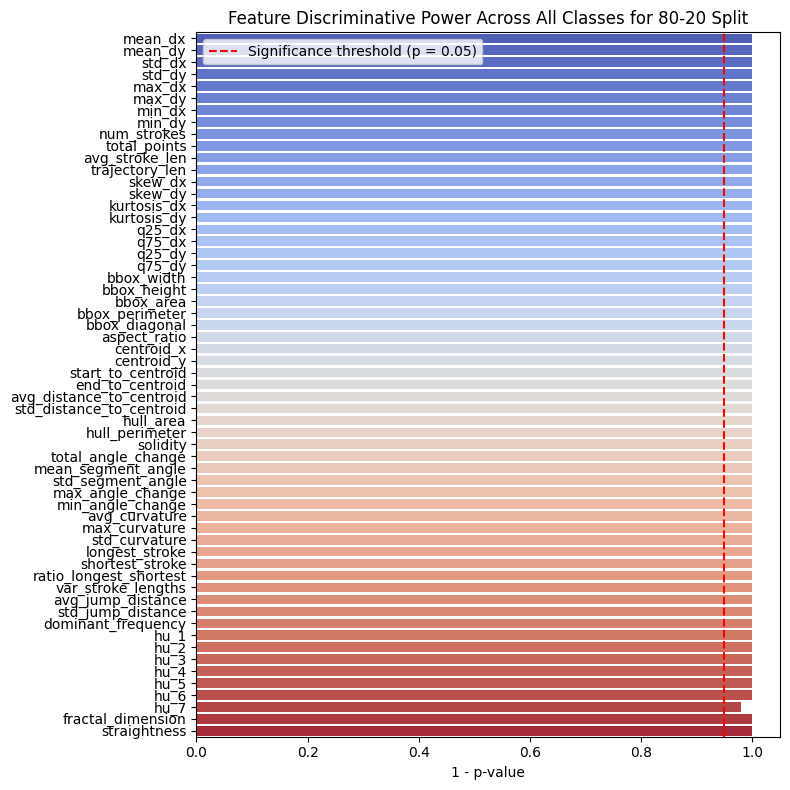

In [ ]:
# ANOVA (analysis of variance) for multiple class comparison

anova_scores = []
for feature in col:
    groups = [group[feature].values for name, group in train_df80.groupby('label')]
    f_stat, p_val = f_oneway(*groups)
    
    anova_scores.append(1 - p_val)  #higher = more discriminative

plt.figure(figsize=(8, 8))
sns.barplot(x=anova_scores, y=col, hue=col, palette='coolwarm', legend=False)
plt.axvline(x=(1 - 0.05), color='red', linestyle='--', label='Significance threshold (p = 0.05)')
plt.title('Feature Discriminative Power Across All Classes for 80-20 Split')
plt.xlabel('1 - p-value')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# 1. Feature Selection: Sequential Forward Floating Selection (SFFS)
#logistic regression as classifier

def sffs_feature_selection(df, label_column='label', classifier=None, scoring='accuracy', cv=5, max_features=None):
    X = df.drop(columns=[label_column])
    y = df[label_column]
    all_features = list(X.columns)
    
    if max_features is None:
        max_features = len(all_features)
    
    selected_features = []
    remaining_features = all_features.copy()
    best_score = 0.0
    
    while remaining_features and len(selected_features) < max_features:
        candidate_scores = {}
        #floating forward step
        for feature in remaining_features:
            candidate_set = selected_features + [feature]
            X_candidate = X[candidate_set]
            score = cross_val_score(classifier, X_candidate, y, cv=cv, scoring=scoring).mean()
            candidate_scores[feature] = score
        
        #pick highest score feature when added
        best_candidate = max(candidate_scores, key=candidate_scores.get)
        best_candidate_score = candidate_scores[best_candidate]
        
        if best_candidate_score > best_score:
            selected_features.append(best_candidate)
            remaining_features.remove(best_candidate)
            best_score = best_candidate_score
            
            #floating backward step
            improvement = True
            while improvement and len(selected_features) > 1:
                removal_scores = {}
                for feature in selected_features:
                    candidate_set = selected_features.copy()
                    candidate_set.remove(feature)
                    X_candidate = X[candidate_set]
                    score = cross_val_score(classifier, X_candidate, y, cv=cv, scoring=scoring).mean()
                    removal_scores[feature] = score
                #pick highest score feature when removed
                best_feature_to_remove = max(removal_scores, key=removal_scores.get)
                best_removal_score = removal_scores[best_feature_to_remove]

                if best_removal_score > best_score:
                    selected_features.remove(best_feature_to_remove)
                    best_score = best_removal_score
                    #add removed feature back to pool
                    remaining_features.append(best_feature_to_remove)
                else:
                    improvement = False
        else:
            break
    return selected_features, best_score

classifier = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42)

selected_features70, best_score70 = sffs_feature_selection(train_df70, label_column='label',
                                                        classifier=classifier, scoring='accuracy', cv=3)
print("Selected Features for 70-30 training sample size:", selected_features70)
print("Best Cross-Validated Score:", best_score70)

selected_features80, best_score80 = sffs_feature_selection(train_df80, label_column='label',
                                                        classifier=classifier, scoring='accuracy', cv=3)
print("Selected Features for 80-20 training sample size:", selected_features80)
print("Best Cross-Validated Score:", best_score80)

selected_features90, best_score90 = sffs_feature_selection(train_df90, label_column='label',
                                                        classifier=classifier, scoring='accuracy', cv=3)
print("Selected Features for 90-10 training sample size:", selected_features90)
print("Best Cross-Validated Score:", best_score90)


Selected Features for 70-30 training sample size: ['avg_distance_to_centroid', 'std_dx', 'trajectory_len', 'total_points', 'total_angle_change', 'q75_dy', 'num_strokes', 'hull_perimeter', 'q25_dy', 'hull_area', 'max_angle_change', 'q25_dx', 'longest_stroke', 'mean_dy', 'std_dy', 'start_to_centroid', 'q75_dx', 'centroid_y', 'min_dy', 'kurtosis_dy', 'straightness', 'kurtosis_dx', 'hu_5']
Best Cross-Validated Score: 0.8000000122431494
Selected Features for 80-20 training sample size: ['avg_distance_to_centroid', 'std_dx', 'total_points', 'total_angle_change', 'num_strokes', 'q75_dy', 'hull_perimeter', 'hull_area', 'q25_dx', 'centroid_y', 'max_angle_change', 'q25_dy', 'q75_dx', 'straightness', 'longest_stroke', 'hu_1', 'std_dy', 'start_to_centroid', 'min_dy', 'skew_dy', 'hu_2', 'std_distance_to_centroid', 'avg_stroke_len', 'mean_dy', 'var_stroke_lengths', 'bbox_height']
Best Cross-Validated Score: 0.8026251969816601
Selected Features for 90-10 training sample size: ['total_points', 'total_

In [ ]:
#selected_features70 = ['avg_distance_to_centroid', 'std_dx', 'trajectory_len', 'total_points', 'total_angle_change', 'q75_dy', 'num_strokes', 'hull_perimeter', 'q25_dy', 'hull_area', 'max_angle_change', 'q25_dx', 'longest_stroke', 'mean_dy', 'std_dy', 'start_to_centroid', 'q75_dx', 'centroid_y', 'min_dy', 'kurtosis_dy', 'straightness', 'kurtosis_dx', 'hu_5']
#selected_features80 = ['avg_distance_to_centroid', 'std_dx', 'total_points', 'total_angle_change', 'num_strokes', 'q75_dy', 'hull_perimeter', 'hull_area', 'q25_dx', 'centroid_y', 'max_angle_change', 'q25_dy', 'q75_dx', 'straightness', 'longest_stroke', 'hu_1', 'std_dy', 'start_to_centroid', 'min_dy', 'skew_dy', 'hu_2', 'std_distance_to_centroid', 'avg_stroke_len', 'mean_dy', 'var_stroke_lengths', 'bbox_height']
#selected_features90 = ['total_points', 'total_angle_change', 'avg_distance_to_centroid', 'q75_dy', 'num_strokes', 'q25_dx', 'hull_perimeter', 'hull_area', 'q25_dy', 'longest_stroke', 'max_angle_change', 'centroid_y', 'std_dx', 'std_dy', 'start_to_centroid', 'mean_dy', 'q75_dx', 'hu_1', 'std_distance_to_centroid', 'kurtosis_dy', 'shortest_stroke', 'hu_2', 'solidity', 'mean_segment_angle', 'hu_4']

In [ ]:
# create new df with only selected features

def create_selected_df(selected_features, train, val, test):
    train_df = train[selected_features + ['label']]
    val_df = val[selected_features + ['label']]
    test_df = test[selected_features + ['label']]
    return train_df, val_df, test_df

train_sdf70, val_sdf70, test_sdf70 = create_selected_df(selected_features70, train_df70, val_df70, test_df70)
train_sdf80, val_sdf80, test_sdf80 = create_selected_df(selected_features80, train_df80, val_df80, test_df80)
train_sdf90, val_sdf90, test_sdf90 = create_selected_df(selected_features90, train_df90, val_df90, test_df90)

principle component following 0.95 rule for 70-30 split: 14
principle component following 0.95 rule for 80-20 split: 16
principle component following 0.95 rule for 90-10 split: 15


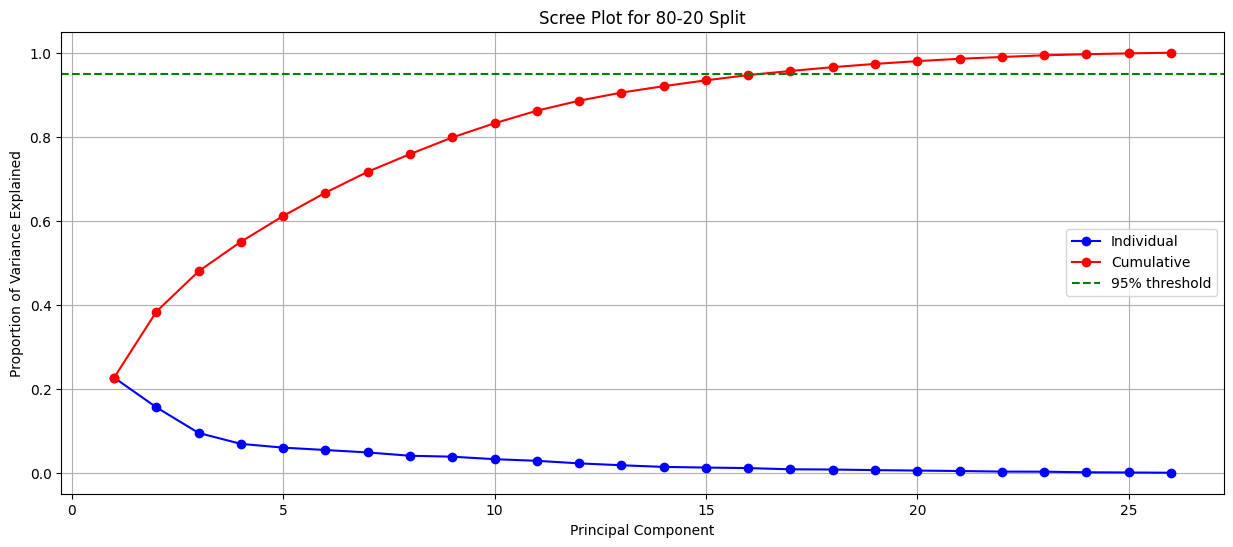

In [14]:
# 2. Feature Projection: Principle Component Analysis (PCA)

# Scree plot to choose number of principle components

def scree_plot(train_df):
    # perform SVD
    X = train_df.drop(columns=['label']).values
    U, s, Vt = np.linalg.svd(X, full_matrices=False)
    V = Vt.T

    var_exp = s**2 / np.sum(s**2)
    cum_var_exp = np.cumsum(var_exp)
    pc_point = np.argmax(cum_var_exp >= 0.95)
    return X, var_exp, cum_var_exp, pc_point

X80, var_exp80, cum_var_exp80, pc_point80 = scree_plot(train_sdf80)
fig = plt.figure(figsize=(15, 6))
plt.plot(range(1, len(var_exp80) + 1), var_exp80, 'bo-', label='Individual')
plt.plot(range(1, len(cum_var_exp80) + 1), cum_var_exp80, 'ro-', label='Cumulative')
plt.axhline(y=0.95, color='green', linestyle='--', label='95% threshold')
plt.xlabel('Principal Component')
plt.ylabel('Proportion of Variance Explained')
plt.title('Scree Plot for 80-20 Split')
plt.legend()
plt.grid(True)

X70, var_exp70, cum_var_exp70, pc_point70 = scree_plot(train_sdf70)
X90, var_exp90, cum_var_exp90, pc_point90 = scree_plot(train_sdf90)

# find # principle components that explain 95% cumulative variance
print("principle component following 0.95 rule for 70-30 split:", pc_point70)
print("principle component following 0.95 rule for 80-20 split:", pc_point80)
print("principle component following 0.95 rule for 90-10 split:", pc_point90)


In [ ]:
# reduce each split to x principle components using PCA by 95% rule

# 70-30
Y = val_sdf70.drop(columns=['label']).values
Z = test_sdf70.drop(columns=['label']).values

pca = PCA(n_components=14)
X_train70_pca = pca.fit_transform(X70)
X_val70_pca = pca.transform(Y)
X_test70_pca = pca.transform(Z)

y_train70 = train_sdf70['label'].values
y_val70 = val_sdf70['label'].values
y_test70 = test_sdf70['label'].values

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.24118534 0.16491262 0.11081371 0.07542332 0.06516558 0.05581557
 0.05038987 0.03915877 0.0342101  0.02971155 0.0255394  0.02002959
 0.01779433 0.01735677]


In [16]:
# 80-20
Y = val_sdf80.drop(columns=['label']).values
Z = test_sdf80.drop(columns=['label']).values

pca = PCA(n_components=16)
X_train80_pca = pca.fit_transform(X80)
X_val80_pca = pca.transform(Y)
X_test80_pca = pca.transform(Z)

y_train80 = train_sdf80['label'].values
y_val80 = val_sdf80['label'].values
y_test80 = test_sdf80['label'].values

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.22756758 0.15699107 0.09604008 0.0701021  0.06116457 0.05549494
 0.0496952  0.04191011 0.03960206 0.03374558 0.02983862 0.02378445
 0.0192554  0.01534355 0.01381747 0.01253135]


In [17]:
# 90-10
Y = val_sdf90.drop(columns=['label']).values
Z = test_sdf90.drop(columns=['label']).values

pca = PCA(n_components=15)
X_train90_pca = pca.fit_transform(X90)
X_val90_pca = pca.transform(Y)
X_test90_pca = pca.transform(Z)

y_train90 = train_sdf90['label'].values
y_val90 = val_sdf90['label'].values
y_test90 = test_sdf90['label'].values

print("Explained variance ratio:", pca.explained_variance_ratio_)

Explained variance ratio: [0.26075281 0.13499044 0.10336728 0.08055979 0.06039864 0.05593897
 0.03894643 0.03850188 0.03298729 0.03172382 0.02637014 0.0246093
 0.02075096 0.01523322 0.01436116]


In [92]:
pca_df = pd.DataFrame(X_train80_pca[:, :3], columns=['PCA Component 1', 'PCA Component 2', 'PCA Component 3'])
pca_df['label'] = y_train80
fig = px.scatter_3d(pca_df, 
                    x='PCA Component 1', 
                    y='PCA Component 2', 
                    z='PCA Component 3', 
                    color='label', 
                    color_continuous_scale='viridis',
                    title="PCA plot for first 3 principle components of 80-20 split",
                   )
fig.show()

In [ ]:
# 3. Feature Projection: Multiple Discriminant Analysis (MDA)
#number of discriminant components at most (n_classes - 1)

def mda_transform(X_train_pca, X_val_pca, X_test_pca, y_train):
    lda = LDA()
    X_train_mda = lda.fit_transform(X_train_pca, y_train)
    X_val_mda = lda.transform(X_val_pca)
    X_test_mda = lda.transform(X_test_pca)
    print("LDA (MDA) Explained Variance Ratio:", lda.explained_variance_ratio_)
    return X_train_mda, X_val_mda, X_test_mda

X_train70_mda, X_val70_mda, X_test70_mda = mda_transform(X_train70_pca, X_val70_pca, X_test70_pca, y_train70)
X_train80_mda, X_val80_mda, X_test80_mda = mda_transform(X_train80_pca, X_val80_pca, X_test80_pca, y_train80)
X_train90_mda, X_val90_mda, X_test90_mda = mda_transform(X_train90_pca, X_val90_pca, X_test90_pca, y_train90)


LDA (MDA) Explained Variance Ratio: [0.43790785 0.28241507 0.0904926  0.07650509 0.05315388 0.02502794
 0.01808026 0.01308451 0.0033328 ]
LDA (MDA) Explained Variance Ratio: [0.44805025 0.25208583 0.1031017  0.06225349 0.06030038 0.03210327
 0.02473342 0.01294966 0.00442201]
LDA (MDA) Explained Variance Ratio: [0.45121177 0.25205289 0.10746718 0.07020129 0.04648681 0.03066432
 0.02476351 0.01359849 0.00355374]


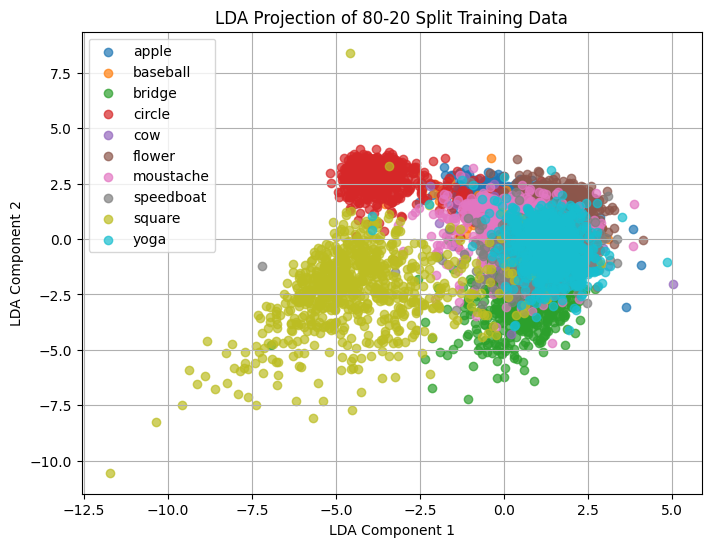

In [ ]:
# visualize first 2 MDA components

plt.figure(figsize=(8, 6))    
for label in np.unique(y_train80):
    indices = (y_train80 == label)
    plt.scatter(X_train80_mda[indices, 0], X_train80_mda[indices, 1],
                label=label, alpha=0.7)
plt.xlabel('MDA Component 1')
plt.ylabel('MDA Component 2')
plt.title('MDA Projection of 80-20 Split Training Data')
plt.legend()
plt.grid(True)
plt.show()

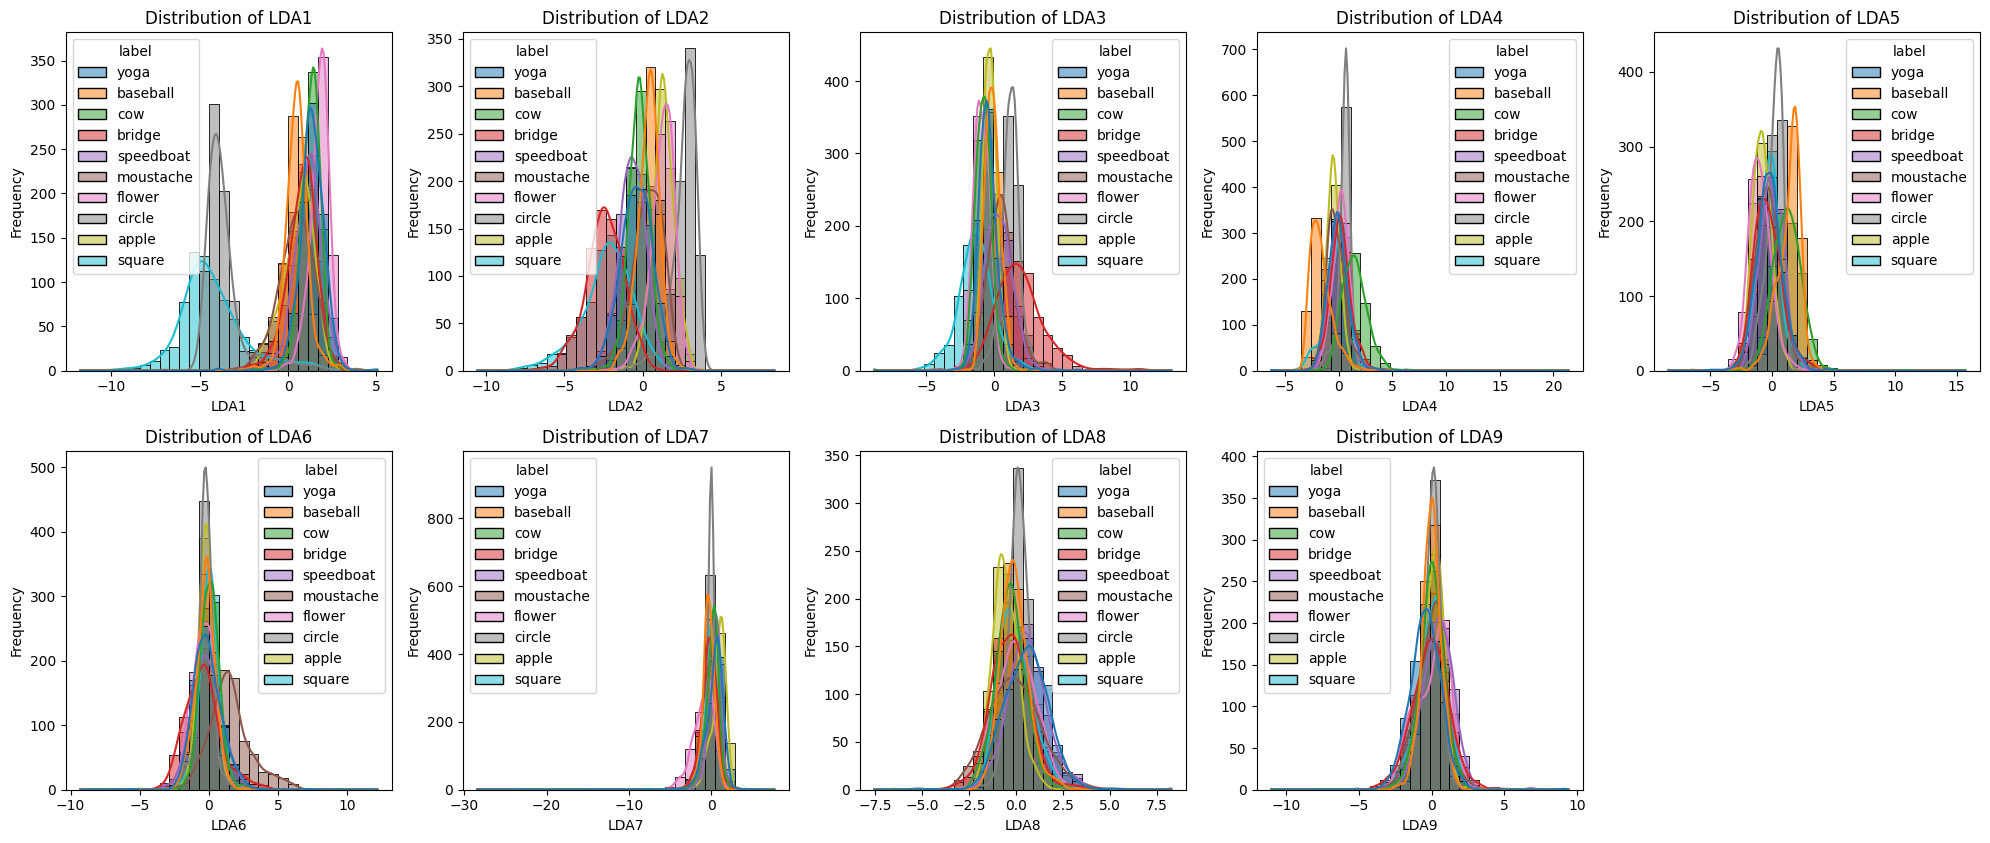

In [ ]:
# plot distribution for each feature for 80-20 split

n_components = X_train80_mda.shape[1]
column_names = [f'LDA{i+1}' for i in range(n_components)]

df_train_mda = pd.DataFrame(X_train80_mda, columns=column_names)
df_train_mda['label'] = y_train80
features = [col for col in df_train_mda.columns if col != 'label']

fig, axes = plt.subplots(12, 5, figsize=(20, 50))
axes = axes.flatten()
for ax, feature in zip(axes, features):
    sns.histplot(data=df_train_mda, x=feature, hue="label", bins=30, kde=True, ax=ax)
    ax.set_title(f'Distribution of {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Frequency')
    
for ax in axes[len(features):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [19]:
# encode for preprocessing
le = LabelEncoder()
y_train70_num = le.fit_transform(y_train70)
y_train80_num = le.fit_transform(y_train80)
y_train90_num = le.fit_transform(y_train90)
label_mapping = dict(zip(le.classes_, range(len(le.classes_))))
print("Label mapping:", label_mapping)

Label mapping: {'apple': 0, 'baseball': 1, 'bridge': 2, 'circle': 3, 'cow': 4, 'flower': 5, 'moustache': 6, 'speedboat': 7, 'square': 8, 'yoga': 9}


Modeling

Bayesian Classifiers (based on the maximum a posteriori principle)

i. Estimate class-conditional PDFs assuming a Multi-Variate Gaussian density function

In [25]:
def bayes_classifier(X_train_mda, X_test_mda, y_train_num, y_test, title=None):
    # get priors
    classes, counts = np.unique(y_train_num, return_counts=True)
    priors = counts / np.sum(counts)
    prior_dict = dict(zip(classes, priors))

    # get parameters
    mean_j = {}
    covariance_j = {}
    for i in sorted(np.unique(y_train_num)):
        subset = X_train_mda[y_train_num == i]
        mean = np.mean(subset, axis=0)
        cov = np.cov(subset, rowvar=False, bias=True)
        mean_j[i] = mean
        covariance_j[i] = cov

    def max_posteriori(x):
        posteriors = []
        for cls in sorted(prior_dict.keys()):
            # get likelihood
            likelihood = multivariate_normal.pdf(x, mean=mean_j[cls], cov=covariance_j[cls])
            posterior = likelihood * prior_dict[cls]
            posteriors.append(posterior)
        return np.argmax(posteriors)

    y_pred = np.array([max_posteriori(x) for x in X_test_mda])
    y_pred = pd.Series(y_pred)
    y_pred = pd.Series(le.inverse_transform(y_pred), name="predicted_class")
    c = confusion_matrix(y_test, y_pred)
    total = np.sum(c)
    correct = np.trace(c)
    acc = (correct)*100 / total
    confusion_df = pd.DataFrame(c, index=le.classes_, columns=le.classes_)

    print("")
    print(title)
    print(f'Empirical Accuracy = {acc:.3f}%')
    print('Confusion matrix = ')
    print(confusion_df)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print("Classification Report:")
    print(report)

bayes_classifier(X_train70_mda, X_test70_mda, y_train70_num, y_test70, 
                 title='Classification Results for 70-30 training sample size:')
bayes_classifier(X_train80_mda, X_test80_mda, y_train80_num, y_test80, 
                 title='Classification Results for 80-20 training sample size:')
bayes_classifier(X_train90_mda, X_test90_mda, y_train90_num, y_test90, 
                 title='Classification Results for 90-10 training sample size:')



Classification Results for 70-30 training sample size:
Empirical Accuracy = 75.600%
Confusion matrix = 
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple        140         1       0       4    1       4          2          1   
baseball       3       110       2       5    8       2          4          3   
bridge         0         1     110       0    0       2          3         12   
circle         2         4       0     139    0       0          3          2   
cow            4         3       0       0  116       6          0          7   
flower         9         1       0       0    7     139          0          1   
moustache     14         3       6       2    8       3         89         14   
speedboat      3         7      12       1   17       0         14         86   
square         2         0       5       3    1       0          0          1   
yoga           9         6      11       0    8       8          4         21   

   

ii. Estimate class-conditional PDFs assuming that features are independent and that every feature variable can be modeled using a Gaussian

In [ ]:
def bayes_classifier2(X_train_ind, X_test_ind, y_train_num, y_test, title=None):
    # get priors
    classes, counts = np.unique(y_train_num, return_counts=True)
    priors = counts / np.sum(counts)
    prior_dict = dict(zip(classes, priors))
    
    # get parameters
    mean_j_ind = {}
    var_j_ind = {}
    for i in sorted(np.unique(y_train_num)):
        subset = X_train_ind[y_train_num == i]
        n = subset.shape[0]
        # get θ_1
        mean = np.sum(subset, axis=0) / n
        # get θ_2
        var = np.sum((subset - mean)**2, axis=0) / n
        mean_j_ind[i] = mean
        var_j_ind[i] = np.diag(var)

    def max_posteriori_ind(x):
        posteriors = []
        for cls in sorted(prior_dict.keys()):
            # get likelihood
            likelihood = multivariate_normal.pdf(x, mean=mean_j_ind[cls], cov=var_j_ind[cls], allow_singular=True)
            posterior = likelihood * prior_dict[cls]
            posteriors.append(posterior)
        return np.argmax(posteriors)
    
    y_pred = np.array([max_posteriori_ind(x) for x in X_test_ind])
    y_pred = pd.Series(y_pred)
    y_pred = pd.Series(le.inverse_transform(y_pred), name="predicted_class")
    c = confusion_matrix(y_test, y_pred)
    total = np.sum(c)
    correct = np.trace(c)
    acc = (correct) * 100 / total
    confusion_df = pd.DataFrame(c, index=le.classes_, columns=le.classes_)

    print("")
    print(title)
    print(f'Empirical Accuracy = {acc:.3f}%')
    print('Confusion matrix = ')
    print(confusion_df)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print("Classification Report:")
    print(report)

bayes_classifier2(X_train70_mda, X_test70_mda, y_train70_num, y_test70,
                              title='Classification Results for 70-30 training sample size:')
bayes_classifier2(X_train80_mda, X_test80_mda, y_train80_num, y_test80,
                              title='Classification Results for 80-20 training sample size:')
bayes_classifier2(X_train90_mda, X_test90_mda, y_train90_num, y_test90,
                              title='Classification Results for 90-10 training sample size:')



Classification Results for 70-30 training sample size:
Empirical Accuracy = 72.933%
Confusion matrix = 
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple        134         2       0       5    3       9          2          1   
baseball       4       110       1       3   10       2          5          3   
bridge         0         0     108       0    3       2          4         13   
circle         3         4       0     140    0       1          2          2   
cow            4         4       1       0  112       8          1          8   
flower        18         1       0       0    8     126          0          0   
moustache     26         5       7       4    5       5         76         13   
speedboat      3         5       9       0   10       1         18         91   
square         1         1       9       3    1       0          2          1   
yoga           9         9       7       0   10       6          4         26   

   

iii. Estimate class-conditional density values of a test sample using the Parzen-Window non-parametric density estimation scheme using Spherical Gaussian kernel

In [31]:
np.random.seed(42)

# choose best window through 5-fold cross-validation
def best_window(X_train, h_n, cv=5):
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    avg_log_likelihood = []
    for h in h_n:
        total_log_likelihood = 0.0
        total_points = 0
        for train_idx, val_idx in kf.split(X_train):
            X_tr = X_train[train_idx]
            X_val = X_train[val_idx]
            dens = parzenwindow(X_val, X_tr, h)
            total_log_likelihood += np.sum(np.log(dens + 1e-12))
            total_points += X_val.shape[0]
        avg_log_likelihood.append(total_log_likelihood / total_points)
    best_idx = np.argmax(avg_log_likelihood)
    return h_n[best_idx], pd.DataFrame({"h": h_n, "avg_log_likelihood": avg_log_likelihood})

def parzenwindow(x, train, h):
    n, d = train.shape
    density_val = np.zeros(x.shape[0])
    for i, point in enumerate(x):
        kernel = multivariate_normal.pdf(((point - train) / h), mean=np.zeros(d), cov=np.eye(d))
        density_val[i] = np.sum(kernel) / (n * (h**d))
    return density_val

def bayes_classifier3(X_train, X_test, y_train, y_test, h_n, title=None):
    classes = np.unique(y_train)
    train_class = {cls: X_train[y_train == cls] for cls in classes}
    h, cv_results = best_window(X_train, h_n)

    def max_posteriori(x):
        posteriors = []
        for cls in classes:
            likelihood = parzenwindow(np.array([x]), train_class[cls], h)[0]
            posteriors.append(likelihood)
        return np.argmax(posteriors)

    y_pred = np.array([max_posteriori(x) for x in X_test])
    y_pred = pd.Series(y_pred)
    y_pred = pd.Series(le.inverse_transform(y_pred), name="predicted_class")
    c = confusion_matrix(y_test, y_pred)
    total = np.sum(c)
    correct = np.trace(c)
    acc = (correct) * 100 / total
    confusion_df = pd.DataFrame(c, index=le.classes_, columns=le.classes_)

    print("")
    print(title)
    print("Best h:", h)
    display(cv_results)
    print(f'Empirical Accuracy = {acc:.3f}%')
    print('Confusion matrix = ')
    print(confusion_df)
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    print("Classification Report:")
    print(report)


h_n = [0.01, 0.1, 0.5, 1, 2, 5, 10]
bayes_classifier3(X_train70_mda, X_test70_mda, y_train70_num, y_test70, h_n, 
                  title='Classification Results for 70-30 training sample size:')
bayes_classifier3(X_train80_mda, X_test80_mda, y_train80_num, y_test80, h_n,
                  title='Classification Results for 80-20 training sample size:')
bayes_classifier3(X_train90_mda, X_test90_mda, y_train90_num, y_test90, h_n,
                  title='Classification Results for 90-10 training sample size:')


Classification Results for 70-30 training sample size:
Best h: 0.5


h  avg_log_likelihood
0   0.01          -27.631021
1   0.10          -25.312132
2   0.50          -12.339702
3   1.00          -13.933854
4   2.00          -17.166647
5   5.00          -23.361461
6  10.00          -27.434595

Empirical Accuracy = 77.200%
Confusion matrix = 
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple        142         2       0       2    3       4          0          1   
baseball       7       109       0       2   10       1          3          4   
bridge         0         1     112       0    2       0          6         13   
circle         3         4       0     140    0       0          4          1   
cow            2         4       0       0  120       5          0          3   
flower         4         1       1       0    6     140          1          0   
moustache     15         0       8       1    6       2         97         13   
speedboat      6         9       8       0   11       0         14         86   
square         3         0       4       3    1       0          3          0   
yoga          10         3       7       0   12       3          4         19   

           square  yoga  
apple           0     6  
basebal

h  avg_log_likelihood
0   0.01          -27.631021
1   0.10          -25.400611
2   0.50          -12.307140
3   1.00          -13.896186
4   2.00          -17.143262
5   5.00          -23.369114
6  10.00          -27.435122

Empirical Accuracy = 77.700%
Confusion matrix = 
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple         89         0       0       2    1       4          0          2   
baseball       2        85       0       1    4       3          5          3   
bridge         0         0      76       0    1       0          6         10   
circle         2         1       0      89    0       0          4          0   
cow            0         1       1       0   88       2          1          3   
flower         4         0       0       0    3      78          1          0   
moustache      5         2       4       2    4       3         79         10   
speedboat      5         1       5       1   18       3          6         56   
square         2         0       4       3    1       0          0          0   
yoga           4         6       0       0   12       1          0         10   

           square  yoga  
apple           0     2  
basebal

h  avg_log_likelihood
0   0.01          -27.631021
1   0.10          -25.026222
2   0.50          -12.062780
3   1.00          -13.828717
4   2.00          -17.134043
5   5.00          -23.365837
6  10.00          -27.434939

Empirical Accuracy = 76.600%
Confusion matrix = 
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple         46         0       0       1    4       4          0          0   
baseball       1        39       1       0    1       1          1          1   
bridge         1         0      39       0    1       0          2          6   
circle         1         2       0      37    0       0          4          0   
cow            1         1       0       0   40       0          1          4   
flower         2         0       0       0    2      45          0          0   
moustache      1         2       3       0    4       3         39          3   
speedboat      3         0       5       0    6       0          1         24   
square         0         1       2       2    0       0          0          0   
yoga           4         0       1       0    3       1          1          6   

           square  yoga  
apple           0     0  
basebal

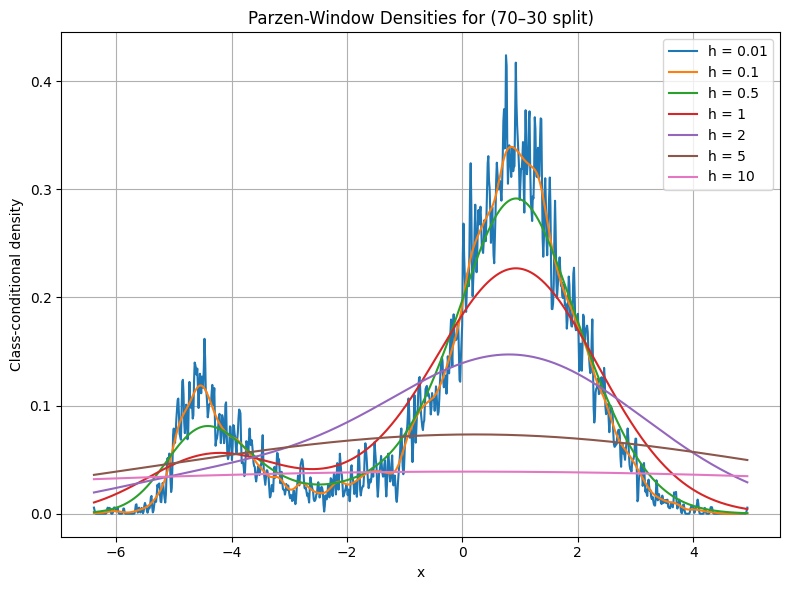

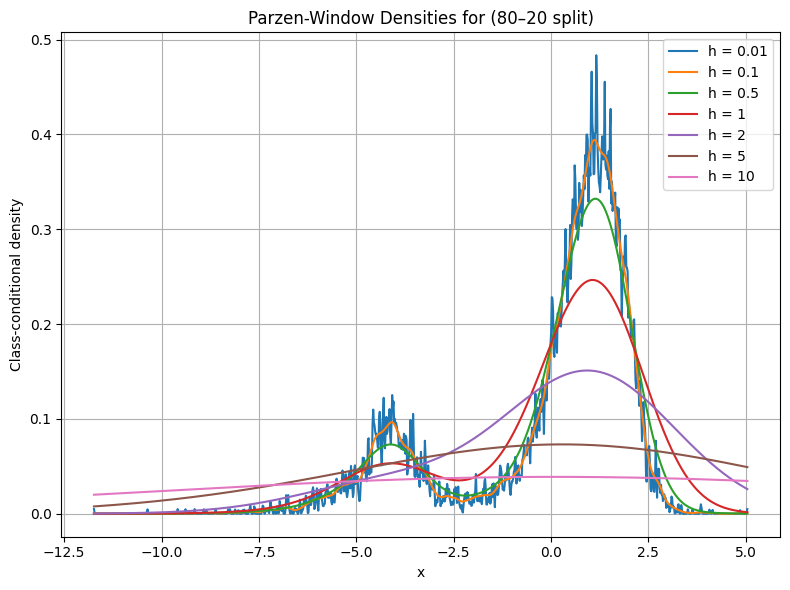

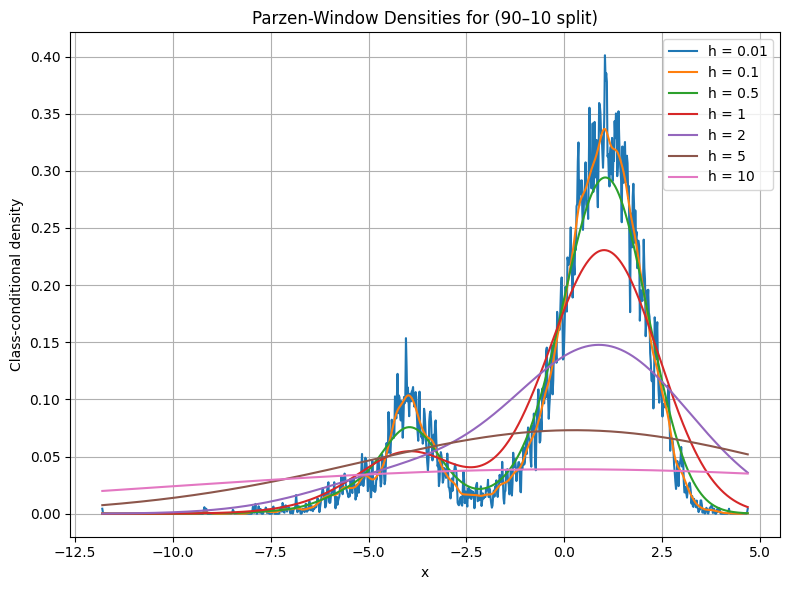

In [33]:
# Plotting Parzen-window densities for the first feature
def plot_parzenwindow(X_train, h_n, split_name):
    feature1 = X_train[:, 0].reshape(-1, 1)
    x_grid = np.linspace(feature1.min(), feature1.max(), 1000).reshape(-1, 1)

    plt.figure(figsize=(8, 6))
    for h in h_n:
        d = parzenwindow(x_grid, feature1, h)
        plt.plot(x_grid[:, 0], d, label=f"h = {h}")

    plt.xlabel("x")
    plt.ylabel("Class-conditional density")
    plt.title(f"Parzen-Window Densities for ({split_name} split)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_parzenwindow(X_train70_mda, h_n, '70–30')
plot_parzenwindow(X_train80_mda, h_n, '80–20')
plot_parzenwindow(X_train90_mda, h_n, '90–10')

Traditional Classifiers (Logistic Regression, SVM, K-NN, XGBoost)

In [ ]:
classifiers = {
    'Logistic Regression': LogisticRegression(solver='liblinear'),
    'SVM': SVC(kernel='rbf'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
}

param_grid = {
    'Logistic Regression': {'C': [0.01, 0.1, 1, 10]},
    'SVM': {'C': [0.01, 0.1, 1, 10]},
    'K-Nearest Neighbors': {'n_neighbors': [3, 5, 7, 10, 15, 20]},
    'XGBoost': {'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
}

#define hypertuning parameters function using validation data
def param_tuning(clf, grid_params, X_train_mda, y_train, X_val_mda, y_val, cv=5):
    best_score = -np.inf
    best_params = {}
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    
    for params in ParameterGrid(grid_params):
        #clone classifier and set its parameters
        clf_candidate = clone(clf)
        clf_candidate.set_params(**params)
        #train on fixed training set
        clf_candidate.fit(X_train_mda, y_train)
        scores = []
        for train_idx, test_idx in kf.split(X_val_mda):
            X_val_fold = X_val_mda[test_idx]
            y_val_fold = y_val[test_idx]
            scores.append(clf_candidate.score(X_val_fold, y_val_fold))
        avg_score = np.mean(scores)
        std_score = np.std(scores)
        if avg_score > best_score:
            best_score = avg_score
            best_std = std_score
            best_params = params
    return best_params, best_score, best_std

def model_eval(X_train_mda, X_val_mda, X_test_mda, y_train, y_val, y_test, le, cv=5):
    y_val_num = le.transform(y_val)

    tuned_models = {}
    model_val_scores = {}
    individual_accuracies = {}
    
    for name, clf in classifiers.items():
        print("=" * 40)
        print(f"{name} Hyperparameter Tuning on Validation Set (CV={cv})")
        grid_params = param_grid.get(name, {})
        best_params, best_val_score, best_val_std = param_tuning(clf, grid_params, X_train_mda, y_train, X_val_mda, y_val_num, cv=cv)
        print("Best Parameters:", best_params)
        print(f"Best Validation CV Score: {best_val_score:.4f} ± {best_val_std:.4f}")
        
        #retrain classifier on full training set with best parameters
        tuned_clf = clone(clf)
        tuned_clf.set_params(**best_params)
        tuned_clf.fit(X_train_mda, y_train)

        tuned_models[name] = tuned_clf
        model_val_scores[name] = best_val_score
        
        predictions_num = tuned_clf.predict(X_test_mda)
        predictions = pd.Series(le.inverse_transform(predictions_num), name="predicted_class")
        true_labels = pd.Series(y_test, name="true_class")
        report = classification_report(true_labels, predictions)
        c = confusion_matrix(true_labels, predictions)
        confusion_df = pd.DataFrame(c, index=le.classes_, columns=le.classes_)
        acc = (np.trace(c)/np.sum(c)) * 100
        individual_accuracies[name] = acc
        
        print("=" * 40)
        print(f"{name} Test Classification Report:")
        print(report)
        print("Confusion matrix:")
        print(confusion_df)
        print(f"Overall Test Accuracy: {acc:.2f}%\n")

    #perform ensemble modeling
    print("=" * 40)
    total_val_acc = sum(model_val_scores.values())
    ensemble_weights = {model_name: score / total_val_acc for model_name, score in model_val_scores.items()}

    print("Model Weights for Ensemble:")
    for model_name, weight in ensemble_weights.items():
        print(f"{model_name}: {weight:.4f}")

    n_samples = X_test_mda.shape[0]
    n_classes = len(le.classes_)
    vote_scores = np.zeros((n_samples, n_classes))

    for name, model in tuned_models.items():
        weight = ensemble_weights[name]
        preds = model.predict(X_test_mda)
        for i, pred in enumerate(preds):
            vote_scores[i, pred] += weight
            
    #ensemble prediction is the class with maximum weighted vote
    ensemble_preds = np.argmax(vote_scores, axis=1)
    ensemble_preds = pd.Series(le.inverse_transform(ensemble_preds), name="predicted_class")
    ensemble_acc = accuracy_score(y_test, ensemble_preds) * 100
    individual_accuracies['Ensemble'] = ensemble_acc

    ensemble_cm = confusion_matrix(y_test, ensemble_preds)
    ensemble_report = classification_report(y_test, ensemble_preds, target_names=le.classes_)

    print("\nEnsemble Model Classification Report:")
    print(ensemble_report)
    print("\nConfusion Matrix:")
    print(pd.DataFrame(ensemble_cm, index=le.classes_, columns=le.classes_))
    print("\nOverall Test Accuracy: {:.2f}%".format(ensemble_acc))

    return individual_accuracies
    

In [25]:
# model training and evaluation for 70-30 split training data
results70 = model_eval(X_train70_mda, X_val70_mda, X_test70_mda, y_train70_num, y_val70, y_test70, le, cv=5)

Logistic Regression Hyperparameter Tuning on Validation Set (CV=5)
Best Parameters: {'C': 10}
Best Validation CV Score: 0.7153 ± 0.0192
Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       apple       0.75      0.81      0.78       160
    baseball       0.76      0.77      0.76       141
      bridge       0.70      0.79      0.74       142
      circle       0.87      0.92      0.89       154
         cow       0.71      0.86      0.78       145
      flower       0.87      0.87      0.87       159
   moustache       0.65      0.61      0.63       145
   speedboat       0.57      0.44      0.50       167
      square       0.94      0.87      0.90       153
        yoga       0.49      0.43      0.46       134

    accuracy                           0.74      1500
   macro avg       0.73      0.74      0.73      1500
weighted avg       0.73      0.74      0.73      1500

Confusion matrix:
           apple  baseball  bridge  cir

c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:56:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:56:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

Best Parameters: {'learning_rate': 0.2, 'max_depth': 5}
Best Validation CV Score: 0.7667 ± 0.0241


c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:56:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Classification Report:
              precision    recall  f1-score   support

       apple       0.86      0.88      0.87       160
    baseball       0.85      0.74      0.79       141
      bridge       0.78      0.80      0.79       142
      circle       0.93      0.92      0.92       154
         cow       0.74      0.81      0.78       145
      flower       0.91      0.91      0.91       159
   moustache       0.74      0.70      0.72       145
   speedboat       0.54      0.54      0.54       167
      square       0.95      0.91      0.93       153
        yoga       0.51      0.57      0.54       134

    accuracy                           0.78      1500
   macro avg       0.78      0.78      0.78      1500
weighted avg       0.78      0.78      0.78      1500

Confusion matrix:
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple        140         2       0       2    3       4          2          2   
baseball       5       10

In [26]:
# model training and evaluation for 80-20 split training data
results80 = model_eval(X_train80_mda, X_val80_mda, X_test80_mda, y_train80_num, y_val80, y_test80, le, cv=5)

Logistic Regression Hyperparameter Tuning on Validation Set (CV=5)
Best Parameters: {'C': 10}
Best Validation CV Score: 0.7320 ± 0.0337
Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       apple       0.81      0.83      0.82       100
    baseball       0.80      0.76      0.78       106
      bridge       0.76      0.82      0.79        99
      circle       0.92      0.92      0.92        96
         cow       0.65      0.86      0.74       101
      flower       0.79      0.88      0.83        89
   moustache       0.72      0.69      0.70       113
   speedboat       0.54      0.41      0.47       114
      square       0.97      0.88      0.92       104
        yoga       0.51      0.45      0.48        78

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.74      1000
weighted avg       0.75      0.75      0.75      1000

Confusion matrix:
           apple  baseball  bridge  cir

c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Validation CV Score: 0.7760 ± 0.0312


c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Classification Report:
              precision    recall  f1-score   support

       apple       0.86      0.84      0.85       100
    baseball       0.84      0.74      0.78       106
      bridge       0.83      0.84      0.83        99
      circle       0.97      0.92      0.94        96
         cow       0.70      0.80      0.75       101
      flower       0.82      0.91      0.86        89
   moustache       0.77      0.70      0.73       113
   speedboat       0.57      0.51      0.54       114
      square       0.94      0.93      0.94       104
        yoga       0.52      0.64      0.57        78

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000

Confusion matrix:
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple         84         1       0       1    2       5          1          4   
baseball       1        7

In [27]:
# model training and evaluation for 90-10 split training data
results90 = model_eval(X_train90_mda, X_val90_mda, X_test90_mda, y_train90_num, y_val90, y_test90, le, cv=5)

Logistic Regression Hyperparameter Tuning on Validation Set (CV=5)
Best Parameters: {'C': 1}
Best Validation CV Score: 0.7420 ± 0.0519
Logistic Regression Test Classification Report:
              precision    recall  f1-score   support

       apple       0.76      0.76      0.76        55
    baseball       0.82      0.93      0.88        45
      bridge       0.76      0.89      0.82        53
      circle       0.93      0.84      0.88        44
         cow       0.67      0.78      0.72        51
      flower       0.77      0.82      0.80        50
   moustache       0.71      0.64      0.67        56
   speedboat       0.50      0.39      0.44        49
      square       0.96      0.89      0.92        53
        yoga       0.66      0.61      0.64        44

    accuracy                           0.76       500
   macro avg       0.75      0.76      0.75       500
weighted avg       0.75      0.76      0.75       500

Confusion matrix:
           apple  baseball  bridge  circ

c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, Us

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7}
Best Validation CV Score: 0.7880 ± 0.0492


c:\Users\manos\anaconda3\envs\streamlitenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:57:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Test Classification Report:
              precision    recall  f1-score   support

       apple       0.73      0.80      0.77        55
    baseball       0.85      0.87      0.86        45
      bridge       0.80      0.83      0.81        53
      circle       0.97      0.86      0.92        44
         cow       0.68      0.75      0.71        51
      flower       0.83      0.90      0.87        50
   moustache       0.88      0.66      0.76        56
   speedboat       0.49      0.47      0.48        49
      square       0.94      0.94      0.94        53
        yoga       0.65      0.70      0.67        44

    accuracy                           0.78       500
   macro avg       0.78      0.78      0.78       500
weighted avg       0.78      0.78      0.78       500

Confusion matrix:
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple         44         1       1       0    2       2          1          0   
baseball       2        3

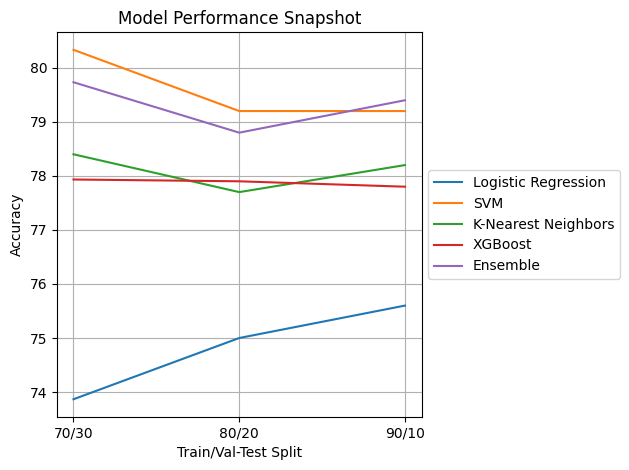

In [38]:
results = {
    '70/30': results70,
    '80/20': results80,
    '90/10': results90
}
df = pd.DataFrame(results).T 
plt.figure()
for model in df.columns:
    plt.plot(df.index, df[model], label=model)
plt.xlabel('Train/Val-Test Split')
plt.ylabel('Accuracy')
plt.title('Model Performance Snapshot')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


In [ ]:
#get mean and variance of error rate with changing training data

all_models = set(results70.keys()) | set(results80.keys()) | set(results90.keys())
accuracy_results = {model: [] for model in all_models}

for results in [results70, results80, results90]:
    for model in all_models:
        accuracy_results[model].append(results.get(model, np.nan))
error_rate_stats = {}
for model, acc_list in accuracy_results.items():
    error_rates = [100 - acc for acc in acc_list]
    mean_error = np.mean(error_rates)
    var_error = np.var(error_rates)
    error_rate_stats[model] = {"mean_error_rate": mean_error, "variance": var_error}

print("\nMean and Variance of Error Rate Over Changing Training Data:")
for model, stats in error_rate_stats.items():
    print(f"{model}: Mean Error Rate: {stats['mean_error_rate']:.2f}% ± {stats['variance']:.4f}")
    


Mean and Variance of Error Rate Over Changing Training Data:
Ensemble: Mean Error Rate: 20.69% ± 0.1491
K-Nearest Neighbors: Mean Error Rate: 21.90% ± 0.0867
SVM: Mean Error Rate: 20.42% ± 0.2854
Logistic Regression: Mean Error Rate: 25.18% ± 0.5165
XGBoost: Mean Error Rate: 22.12% ± 0.0032


Recurrent Neural Networks (RNNs)

In [ ]:
features = {
    "ink": [],
    "shape": []  #number of points in each drawing
}

targets = []
#process train_data
for np_ink, class_name in master_data:
    features["ink"].append(np_ink)  #ink data: processed strokes
    features["shape"].append([len(np_ink)])  #shape: total number of points in ink_data
    targets.append(class_name)

features["ink"] = np.array(features["ink"], dtype=object)
features["shape"] = np.array(features["shape"])
targets = np.array(targets)

# train-test-val-split to 60-20-20
ink_train_val, ink_test, shape_train_val, shape_test, targets_train_val, targets_test = train_test_split(
    features["ink"], features["shape"], targets, test_size=0.2, random_state=42, stratify=targets
)
ink_train, ink_val, shape_train, shape_val, targets_train, targets_val = train_test_split(
    ink_train_val, shape_train_val, targets_train_val, test_size=0.25, random_state=42, stratify=targets_train_val
)
features_train = {"ink": ink_train, "shape": shape_train}
features_val = {"ink": ink_val, "shape": shape_val}
features_test = {"ink": ink_test, "shape": shape_test}

In [ ]:
# encode targets numerically

unique_classes = np.unique(np.concatenate([targets_train, targets_val, targets_test]))
class_to_index = {cls: idx for idx, cls in enumerate(unique_classes)}

def encode_targets(targets_array):
    return np.array([class_to_index[t] for t in targets_array])

targets_train_encoded = encode_targets(targets_train)
targets_val_encoded = encode_targets(targets_val)
targets_test_encoded = encode_targets(targets_test)


In [36]:
# convert data to padded tensors

def convert_to_padded_tensors(features, targets, max_seq_len=None):
    inks = features["ink"]
    lengths = [len(seq) for seq in inks]
    if max_seq_len is None:
        max_seq_len = max(lengths)
    num_samples = len(inks)

    padded_inks = np.zeros((num_samples, max_seq_len, 3), dtype=np.float32)
    for i, seq in enumerate(inks):
        length = len(seq)
        padded_inks[i, :length, :] = seq

    targets = np.array(targets, dtype=np.int64)
    return padded_inks, targets, lengths

X_train, y_train, lengths_train = convert_to_padded_tensors(features_train, targets_train_encoded)
X_val, y_val, lengths_val = convert_to_padded_tensors(features_val, targets_val_encoded, X_train.shape[1])
X_test, y_test, lengths_test = convert_to_padded_tensors(features_test, targets_test_encoded, X_train.shape[1])


In [37]:
# get pytorch datasets

BATCH_SIZE = 32

train_dataset = TensorDataset(torch.tensor(X_train), torch.tensor(y_train), torch.tensor(lengths_train))
val_dataset   = TensorDataset(torch.tensor(X_val), torch.tensor(y_val), torch.tensor(lengths_val))
test_dataset  = TensorDataset(torch.tensor(X_test), torch.tensor(y_test), torch.tensor(lengths_test))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE)


In [ ]:
# define classification model

class DrawingClassifier(nn.Module):
    def __init__(self, conv_filters, lstm_units, num_lstm_layers, dropout_rate, num_classes):
        super(DrawingClassifier, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(3, conv_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(conv_filters, conv_filters, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv1d(conv_filters, conv_filters, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(conv_filters, lstm_units, num_lstm_layers, 
                              batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc = nn.Linear(lstm_units * 2, num_classes)

    def forward(self, x, lengths):
        #x: (batch, seq_len, 3)
        x = x.permute(0, 2, 1)  #(batch, channels, seq_len)
        x = self.conv(x)
        x = x.permute(0, 2, 1)  #(batch, seq_len, channels)

        #pack sequence; lengths should be on CPU (if needed) or convert to list
        lengths = lengths.cpu() if x.is_cuda else lengths
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm(packed_input)
        lstm_out, _ = pad_packed_sequence(packed_output, batch_first=True)

        #extract last valid output for each sequence
        final_outputs = []
        for i, length in enumerate(lengths):
            final_outputs.append(lstm_out[i, length - 1, :])
        final_outputs = torch.stack(final_outputs, dim=0)

        x = self.dropout(final_outputs)
        x = self.fc(x)
        return x


In [ ]:
# hyperparameter tuning on validation set

def objective(trial):
    conv_filters = trial.suggest_categorical('conv_filters', [32, 64, 128])
    lstm_units = trial.suggest_categorical('lstm_units', [128, 256])
    num_lstm_layers = trial.suggest_categorical('num_lstm_layers', [2, 3])
    dropout_rate = trial.suggest_categorical('dropout_rate', [0.3, 0.5])
    learning_rate = trial.suggest_categorical('learning_rate', [1e-3, 5e-4])

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = DrawingClassifier(conv_filters, lstm_units, num_lstm_layers, dropout_rate, len(unique_classes)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(5):
        for X_batch, y_batch, lengths_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            optimizer.zero_grad()
            outputs = model(X_batch, lengths_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

    model.eval()
    correct = total = 0
    with torch.no_grad():
        for X_batch, y_batch, lengths_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            lengths_batch = lengths_batch.to(device)
            
            outputs = model(X_batch, lengths_batch)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == y_batch).sum().item()
            total += y_batch.size(0)

    val_accuracy = correct / total
    return val_accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)

print("Best hyperparameters:", study.best_trial.params)


[I 2025-04-16 02:10:25,448] A new study created in memory with name: no-name-76698eb9-af0b-46b5-b2b0-41bfb111251d
[I 2025-04-16 02:10:53,687] Trial 0 finished with value: 0.565 and parameters: {'conv_filters': 32, 'lstm_units': 256, 'num_lstm_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.0005}. Best is trial 0 with value: 0.565.
[I 2025-04-16 02:11:21,237] Trial 1 finished with value: 0.679 and parameters: {'conv_filters': 128, 'lstm_units': 128, 'num_lstm_layers': 2, 'dropout_rate': 0.5, 'learning_rate': 0.001}. Best is trial 1 with value: 0.679.
[I 2025-04-16 02:11:47,997] Trial 2 finished with value: 0.5365 and parameters: {'conv_filters': 32, 'lstm_units': 128, 'num_lstm_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.0005}. Best is trial 1 with value: 0.679.
[I 2025-04-16 02:12:22,948] Trial 3 finished with value: 0.6535 and parameters: {'conv_filters': 32, 'lstm_units': 128, 'num_lstm_layers': 3, 'dropout_rate': 0.5, 'learning_rate': 0.001}. Best is trial 1 with value: 

Best hyperparameters: {'conv_filters': 128, 'lstm_units': 128, 'num_lstm_layers': 2, 'dropout_rate': 0.3, 'learning_rate': 0.001}


In [42]:
# train model with best hyperparameters

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_params = study.best_trial.params
model_params = {k: v for k, v in best_params.items() if k != 'learning_rate'}
final_model = DrawingClassifier(**model_params, num_classes=len(unique_classes)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(final_model.parameters(), lr=best_params['learning_rate'])

final_model.train()
for epoch in range(20):
    for X_batch, y_batch, lengths_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        lengths_batch = lengths_batch.to(device)
        
        optimizer.zero_grad()
        outputs = final_model(X_batch, lengths_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()


In [44]:
# evaluate best model on test data

final_model.eval()
correct = total = 0
y_true, y_pred = [], []

with torch.no_grad():
    for X_batch, y_batch, lengths_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        lengths_batch = lengths_batch.to(device)
        
        outputs = final_model(X_batch, lengths_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        correct += (predicted == y_batch).sum().item()
        total += y_batch.size(0)

test_accuracy = correct / total
print("Test accuracy:", test_accuracy)
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=unique_classes, columns=unique_classes)
print("Confusion Matrix:")
print(cm_df)
print(classification_report(y_true, y_pred, target_names=unique_classes))


Test accuracy: 0.838
Confusion Matrix:
           apple  baseball  bridge  circle  cow  flower  moustache  speedboat  \
apple        172         8       0       8    4       0          7          0   
baseball       1       182       0       0    2       0          5          4   
bridge         0         1     179       1    1       1          6          8   
circle         7         4       0     178    2       0          6          1   
cow            1         6       1       0  168       0         13          5   
flower         2         0       0       1    7     179          5          0   
moustache      5         1       3       2    9       0        164          9   
speedboat      1         6       4       0    9       1         14        152   
square         0         1       3       5    2       0          4          3   
yoga           3         2       6       3   23      12         11         14   

           square  yoga  
apple           1     0  
baseball        0